# Udacity CarND - Advance Lane Detection Project

<b>Project Instructions</b>

The goals / steps of this project are the following:
1. Camera Calibration
    1.    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Image pipeline
    1.    Apply the distortion correction to the raw image.
    1.    Use color transforms, gradients, etc., to create a thresholded binary image.
    1.    Apply a perspective transform to rectify binary image ("birds-eye view").
    1.    Detect lane pixels and fit to find lane boundary.
    1.    Determine curvature of the lane and vehicle position with respect to center.
    1.    Warp the detected lane boundaries back onto the original image.
1. Video Pipeline
    1.    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

## 1) Camera Calibration

### A. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

First I read all the images using the glob api and initialize the variables obj_points and img_points. I define a function that takes an image, object points, and image points as input and returns the undistorted image. 

In the next cell I generate the "object points" as objp and detect the "image points" as corners and store them in their respective variables. After that I call the cal_undistort function to obtain distortion coefficients and then I save the data in a pickle file.


Assumptions
- The chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.
- All images have 6 rows and 9 columns (mentioned in the project rubric)

In [2]:
# Read images
import glob

images = glob.glob('camera_cal/calibration*.jpg')

nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Initialise image and object point arrays
obj_points = []
img_points = []

# Takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


In [3]:
# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
#         cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         plt.imshow(img)
        img_points.append(corners)
        obj_points.append(objp)
        

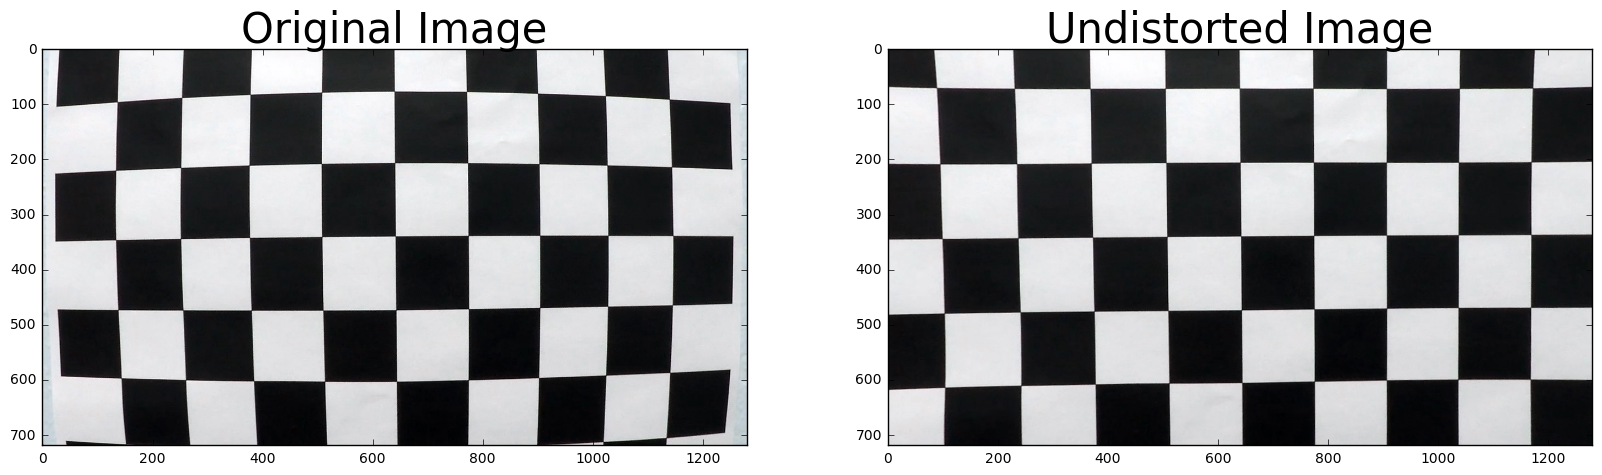

In [4]:
import pickle

image = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(image, obj_points, img_points)
cv2.imwrite('output_images/undistorted.jpg',undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img.shape[0:2], None, None)
cam_cal_pickle = {}
cam_cal_pickle["mtx"] = mtx
cam_cal_pickle["dist"] = dist
pickle.dump(cam_cal_pickle, open("camera_calibration.p", "wb"))

In [5]:
with open("camera_calibration.p", mode='rb') as f:
    cam_cal_pickle = pickle.load(f)
mtx = cam_cal_pickle["mtx"]
dist = cam_cal_pickle["dist"]

## 2) Image pipeline


<sub>Section 2 References https://github.com/jessicayung/self-driving-car-nd/blob/master/p4-advanced-lane-lines</sub>

### A. Distortion-corrected images

Calculated via camera calibration coefficients obtained above.

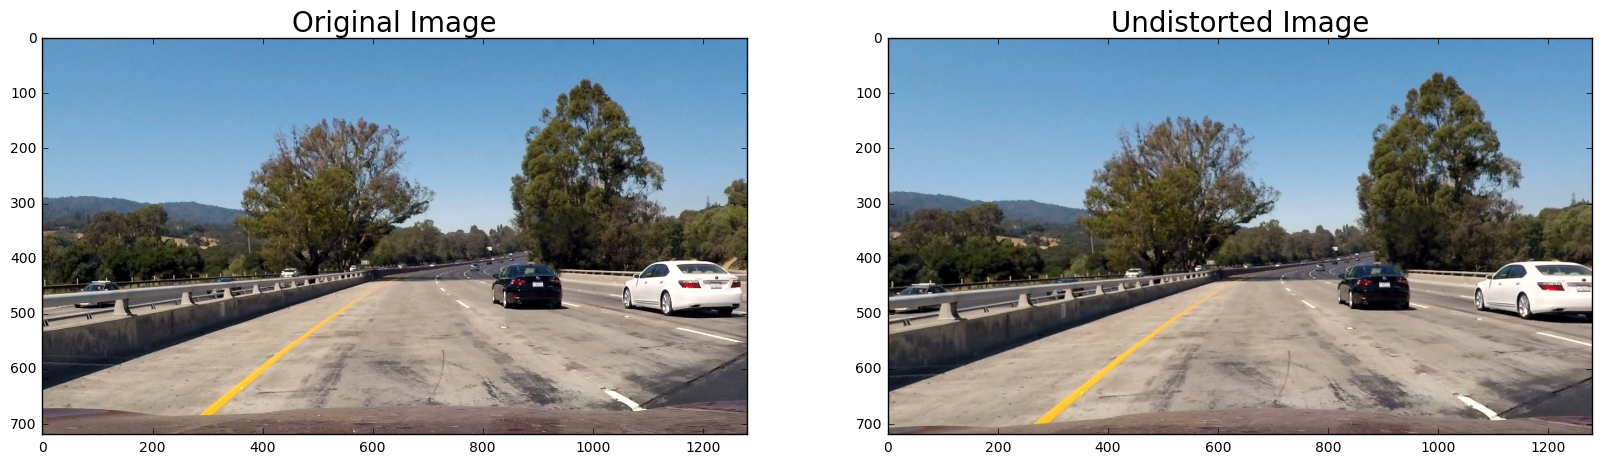

In [6]:
def process_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
images = glob.glob('test_images/*.jpg')

img = cv2.imread(images[-2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

undistorted = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()
    

### B. Use color transforms, gradients, etc., to create a thresholded binary image.

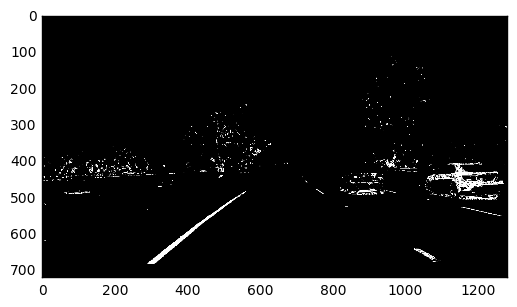

In [7]:
from utils import *

xgrad_thresh_temp = (170,200)
s_thresh_temp=(200,255)

combined_binary = apply_threshold(img, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
plt.imshow(combined_binary, cmap="gray")

### C. Apply a perspective transform to rectify binary image ("birds-eye view")

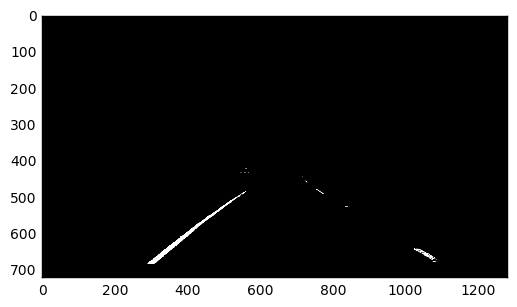

In [8]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = np.array([[(120,img_size[1]),(550, 420), (700, 420), (1160,img_size[1])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

In [9]:
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

def get_perspectives(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

M, Minv = get_perspectives(src, dst)


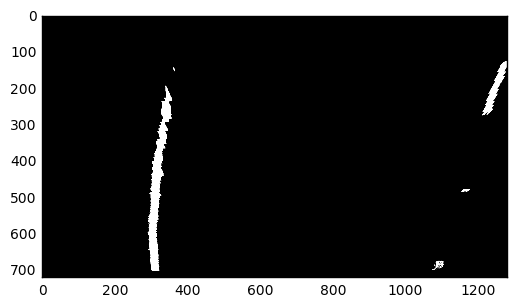

In [10]:
# Warp onto birds-eye-view
# Previous region-of-interest mask's function is absorbed by the warp
warped = cv2.warpPerspective(combined_binary, M, (img_size[0], img_size[1]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

### D. Detect lane pixels and fit to find lane boundary

In [11]:
from utils import *
from scipy import signal

Left coeffs: [  2.47145049e-04  -3.13855435e-01   4.05025630e+02]
righty[0]: , 485.0 , rightx[0]:  1151
Right coeffs:  [  2.33797782e-04  -4.47819708e-01   1.32391089e+03]


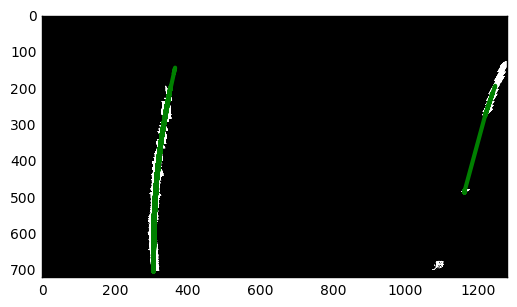

In [12]:
# Histogram and get pixels in window

leftx, lefty, rightx, righty = histogram_pixels(warped, medianfilt_kernel_size=15)

# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

Left coeffs:  [  2.47145049e-04  -3.13855435e-01   4.05025630e+02]
Right fit:  [  2.33797782e-04  -4.47819708e-01   1.32391089e+03]


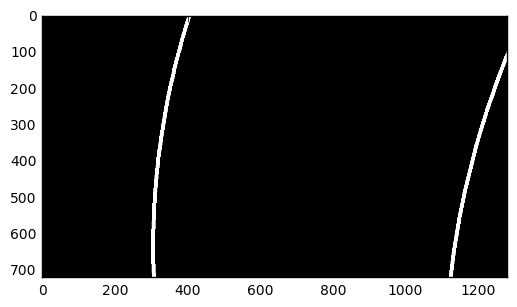

In [13]:
print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)
blank_canvas = np.zeros((720, 1280))
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")

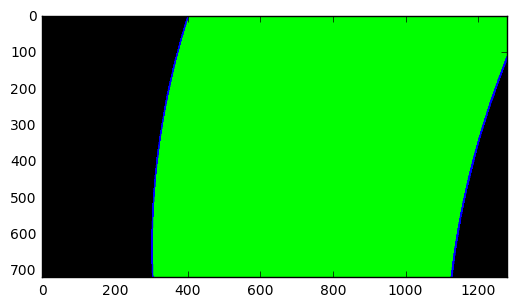

In [14]:
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

trace = colour_canvas
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

###  E. Determine curvature of the lane and vehicle position with respect to center.

In [15]:
# Determine curvature of the lane
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

Left lane curve radius:  2036.62350954 pixels
Right lane curve radius:  2287.20940598 pixels


###  F. Warp the detected lane boundaries back onto the original image.

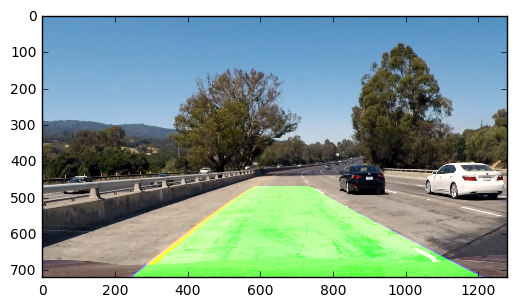

In [16]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (img_size[0], img_size[1]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, img)
plt.imshow(combined_img)

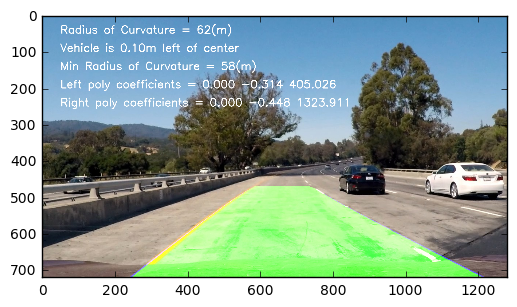

In [17]:
add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)
plt.imshow(combined_img)

## 3) Video Pipeline

### Consolidated Image pipeline for use in video pipeline

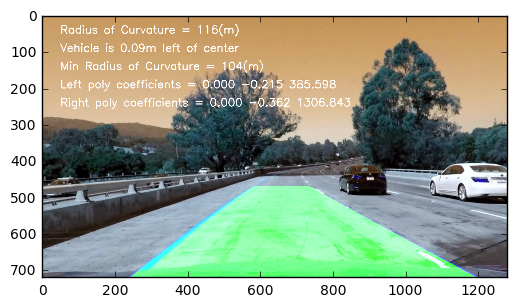

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from utils import *

with open("camera_calibration.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

prev_left_coeffs = None
prev_right_coeffs = None

def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    src = np.float32([[120, 720], [550, 470], [700, 470], [1160, 720]])
    dst = np.float32([[200,720], [200,0], [1080,0], [1080,720]])
    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    
    M, Minv = get_perspectives(src, dst)
    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    xgrad_thresh_temp = (40,100)
    s_thresh_temp=(150,255)
    have_fit = False
    curvature_checked = False
    
    while have_fit == False:
        combined_binary = apply_threshold(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
        leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=40)
        
        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)
        s_thresh_temp = (s_thresh_temp[0] - 2, s_thresh_temp[1] + 2)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
    
    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                    /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     /(2 * right_coeffs[0]))
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)

    # TODO: if plausible parallel, continue. Else don't make `curvature_checked` = True
    if not plausible_curvature(left_curverad, right_curverad) or \
        not plausible_continuation_of_traces(left_coeffs, right_coeffs, prev_left_coeffs, prev_right_coeffs):
            if prev_left_coeffs is not None and prev_right_coeffs is not None:
                left_coeffs = prev_left_coeffs
                right_coeffs = prev_right_coeffs

    prev_left_coeffs = left_coeffs
    prev_right_coeffs = right_coeffs
    
    # Det vehicle position wrt centre
    centre = center(719, left_coeffs, right_coeffs)
        
    ## 7. Warp the detected lane boundaries back onto the original image.
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)

    # Convert to colour and highlight lane line area
    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

    combined_img = cv2.add(lane_lines, image)
    add_figures_to_image(combined_img, curvature=curvature, 
                         vehicle_position=centre, 
                         min_curvature=min_curverad,
                         left_coeffs=left_coeffs,
                         right_coeffs=right_coeffs)
    plt.imshow(combined_img)
    return combined_img

combined_img = image_pipeline("test_images/test1.jpg", filepath=True)

### A. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [10:35<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 38min 24s, sys: 2min 57s, total: 41min 21s
Wall time: 10min 36s


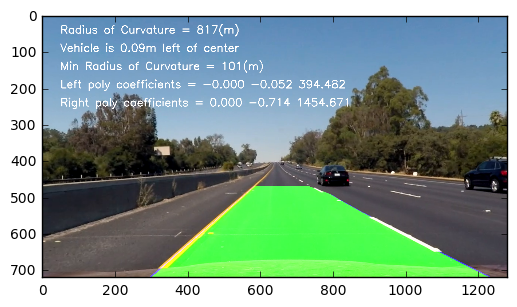

In [20]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline)
%time output_clip.write_videofile(output, audio=False)

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  4%|▎         | 17/485 [00:09<03:09,  2.47it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1000, 1035, 1036, 1036, 1036, 1036, 1037, 1037, 1037, 1037, 1038,
       1038, 1038, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1040, 1040,
       1040, 1040, 1040, 1040, 1040, 1040, 1040, 1041, 1041, 1041, 1041,
       1041, 1042, 1042, 1042, 1042, 1043, 1043, 1043, 1043, 1043, 1044,
       1044, 1044, 1044, 1044, 1044, 1044, 1044, 1045, 1045, 1045, 1045,
       1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1046, 1046,
       1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046,
       1046, 1046, 1046, 1046, 1046, 1046, 1046, 1047, 1047, 1047, 1047,
       1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047,
       1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047,
       1047, 1047, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048,
       1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048,
       1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 10

  4%|▍         | 19/485 [00:10<04:46,  1.63it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1037, 1038, 1039, 1039, 1040, 1040, 1040, 1040, 1040, 1041, 1041,
       1041, 1041, 1041, 1041, 1041, 1041, 1041, 1041, 1041, 1041, 1041,
       1041, 1041, 1041, 1041, 1041, 1041, 1042, 1042, 1042, 1042, 1042,
       1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042,
       1042, 1042, 1042, 1042, 1042, 1042, 1042, 1043, 1043, 1043, 1043,
       1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043,
       1043, 1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044, 1044, 1044,
       1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044,
       1044, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046,
       1046, 1046, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047,
       1047, 1047, 1047, 1047, 1048, 1048, 1048, 1048, 1048, 1048, 1048,
       1048, 1048, 1048, 1048, 1048, 1049, 1049, 1049, 1049, 1049, 1049,
       1049, 1049, 1049, 1049, 1050, 1050, 1050, 1050, 1050, 1050, 10

  7%|▋         | 32/485 [00:16<03:20,  2.26it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1076, 1076, 1076, 1077, 1077, 1077, 1077, 1078, 1078, 1078, 1078,
       1078, 1079, 1079, 1079, 1079, 1079, 1080, 1080, 1080, 1080, 1080,
       1080, 1080, 1080, 1080, 1080, 1081, 1081, 1081, 1081, 1081, 1081,
       1081, 1081, 1081, 1081, 1081, 1081, 1082, 1082, 1082, 1082, 1082,
       1082, 1082, 1082, 1082, 1082, 1082, 1082, 1082, 1083, 1083, 1083,
       1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1084, 1084, 1084,
       1084, 1084, 1084, 1084, 1084, 1084, 1084, 1084, 1084, 1085, 1085,
       1085, 1085, 1085, 1085, 1085, 1085, 1085, 1085, 1085, 1085, 1085,
       1086, 1086, 1086, 1086, 1086, 1086, 1086, 1086, 1086, 1086, 1086,
       1086, 1086, 1086, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087,
       1087, 1087, 1087, 1088, 1088, 1088, 1088, 1088, 1088, 1088, 1088,
       1088, 1088, 1088, 1089, 1089, 1089, 1089, 1089, 1089, 1089, 1089,
       1089, 1089, 1089, 1089, 1089, 1089, 1090, 1090, 1090, 1090, 10

  7%|▋         | 34/485 [00:18<05:07,  1.47it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1005, 1005, 1006, 1006, 1006, 1006, 1006, 1007, 1007, 1007, 1007,
       1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008, 1008, 1008,
       1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009, 1013,
       1014, 1014, 1014, 1015, 1015, 1015, 1016, 1016, 1016, 1017, 1017,
       1017, 1017, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1021, 1022,
       1023, 1023, 1024, 1025, 1025, 1026, 1026, 1026, 1027, 1027, 1028,
       1029, 1030, 1030, 1031, 1068, 1072, 1073, 1073, 1074, 1074, 1074,
       1075, 1075, 1075, 1075, 1075, 1076, 1076, 1076, 1076, 1076, 1076,
       1076, 1076, 1076, 1076, 1076, 1076, 1076, 1077, 1077, 1077, 1077,
       1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077,
       1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078,
       1078, 1078, 1079, 1079, 1079, 1079, 1079, 1079, 1079, 1080, 1080,
       1080, 1080, 1080, 1080, 1081, 1081, 1081, 1081, 1081, 1081, 10

  7%|▋         | 36/485 [00:20<05:11,  1.44it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


  8%|▊         | 37/485 [00:21<05:17,  1.41it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 995,  995,  996,  997,  998,  998, 1000, 1000, 1000, 1001, 1001,
       1002, 1002, 1003, 1003, 1004, 1005, 1005, 1005, 1006, 1006, 1006,
       1006, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008, 1008,
       1008, 1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009,
       1009, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1010, 1010, 1010,
       1010, 1010, 1010, 1010, 1010, 1010, 1010, 1011, 1011, 1011, 1011,
       1011, 1011, 1011, 1011, 1011, 1011, 1011, 1012, 1012, 1012, 1012,
       1012, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1013,
       1013, 1013, 1014, 1014, 1014, 1016, 1018, 1019, 1020, 1027, 1028,
       1029, 1030, 1064, 1065, 1067, 1069, 1070, 1070, 1070, 1070, 1071,
       1071, 1071, 1071, 1071, 1071, 1071, 1072, 1072, 1072, 1072, 1072,
       1072, 1072, 1072, 1072, 1072, 1072, 1073, 1073, 1073, 1073, 1073,
       1073, 1073, 1073, 1073, 1073, 1073, 1073, 1073, 1074, 1074, 10

  9%|▉         | 44/485 [00:24<03:33,  2.07it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 993,  993,  994,  994,  995,  995,  995,  996,  996,  996,  997,
        997,  997,  997,  997,  998,  998,  998,  998,  999,  999,  999,
        999,  999,  999,  999, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1002,
       1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002,
       1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003, 1003,
       1003, 1003, 1003, 1003, 1004, 1004, 1004, 1004, 1004, 1004, 1005,
       1005, 1005, 1005, 1006, 1040, 1041, 1041, 1042, 1044, 1045, 1046,
       1049, 1050, 1052, 1055, 1056, 1056, 1057, 1057, 1058, 1059, 1060,
       1062, 1062, 1097, 1098, 1105, 1105, 1105, 1106, 1106, 1107, 1107,
       1107, 1108, 1109, 1110, 1110, 1111, 1111, 1111, 1113, 1113, 1114,
       1114, 1114, 1114, 1114, 1114, 1114, 1115, 1115, 1115, 1115, 11

  9%|▉         | 45/485 [00:25<04:59,  1.47it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1010, 1010, 1011, 1011, 1012, 1012, 1012, 1012, 1013, 1013, 1013,
       1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014, 1014, 1015, 1015,
       1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1016, 1017, 1017,
       1017, 1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1020, 1020,
       1020, 1020, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1022,
       1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023,
       1023, 1023, 1023, 1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024,
       1024, 1024, 1024, 1024, 1024, 1024, 1025, 1025, 1025, 1025, 1025,
       1025, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027, 1027, 1027, 1027,
       1027, 1027, 1027, 1027, 1027, 1027, 1028, 1028, 1028, 1028, 1028,
       1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
       1028, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 10

  9%|▉         | 46/485 [00:27<06:48,  1.08it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1004, 1004, 1004, 1005, 1005, 1005, 1005, 1006, 1006, 1006, 1006,
       1006, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008,
       1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009, 1009,
       1009, 1009, 1009, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010,
       1010, 1010, 1011, 1011, 1011, 1011, 1011, 1011, 1012, 1012, 1012,
       1012, 1012, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014, 1014,
       1014, 1014, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015,
       1015, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016,
       1016, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017,
       1017, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018,
       1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1019, 1019, 1019,
       1019, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 1020, 1020,
       1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 10

 10%|▉         | 47/485 [00:28<07:10,  1.02it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1001, 1001, 1002, 1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003,
       1003, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1005, 1005, 1005,
       1005, 1005, 1005, 1005, 1005, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008, 1008,
       1008, 1009, 1009, 1009, 1010, 1010, 1010, 1010, 1011, 1011, 1011,
       1011, 1011, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012,
       1012, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013,
       1013, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014,
       1014, 1014, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015,
       1015, 1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1016, 1016,
       1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1017, 1017, 1017,
       1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017,
       1017, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 10

 10%|█         | 49/485 [00:29<05:35,  1.30it/s]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([511, 512, 512, 513, 513, 526, 526, 527, 527, 528, 534, 534, 535,
       535, 535, 536, 538, 539, 558, 558, 559, 559, 568, 569, 569, 569,
       570, 570, 570, 571, 571, 571, 571, 572, 572, 572, 572, 572, 572,
       573, 573, 573, 573, 573, 573, 574, 574, 574, 574, 575, 575, 575,
       575, 576, 576, 576, 577, 583, 583, 584, 584, 584, 585, 585, 585,
       586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 588, 588, 588,
       588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 589, 589,
       590, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591,
       591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 593, 593,
       593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 594, 594,
       594, 595, 595, 595, 595, 595, 595, 5

 11%|█         | 51/485 [00:31<06:25,  1.12it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 875,  875,  875,  876,  876,  876,  877,  877,  877,  877,  878,
        878,  878,  878,  879,  879,  879,  879,  880,  880,  978,  978,
        978,  979,  979,  979,  979,  979,  980,  980,  980,  980,  980,
        980,  980,  981,  981,  981,  981,  981,  981,  982,  982,  982,
        982,  982,  982,  983,  983,  983,  983,  983,  984,  984,  984,
        984,  984,  984,  984,  985,  985,  985,  985,  985,  985,  985,
        985,  985,  986,  986,  986,  986,  986,  986,  986,  986,  986,
        986,  987,  987,  987,  987,  987,  987,  987,  987,  988,  988,
        988,  988,  988,  988,  989,  989,  989,  989,  989,  989,  989,
        990,  990,  990,  990,  990,  990,  991,  991,  991,  991,  991,
        992,  992,  992,  992,  993,  993,  993,  993,  993,  993,  994,
        994,  994,  994,  994,  994,  994,  994,  994,  994,  994,  994,
        994,  995,  995,  995,  995,  995,  995,  995,  995,  995,  9

 11%|█         | 52/485 [00:32<06:10,  1.17it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 867,  867,  868,  868,  868,  869,  869,  869,  870,  870,  870,
        870,  871,  871,  871,  871,  872,  872,  872,  872,  873,  873,
        873,  873,  874,  874,  874,  874,  875,  875,  875,  875,  876,
        876,  876,  877,  877,  877,  878,  878,  879,  879,  880,  880,
        973,  973,  973,  974,  974,  974,  975,  975,  975,  975,  975,
        976,  976,  976,  976,  976,  976,  976,  976,  977,  977,  977,
        977,  977,  977,  977,  977,  977,  977,  978,  978,  978,  978,
        978,  978,  978,  979,  979,  979,  979,  980,  980,  981,  982,
        982,  982,  982,  983,  983,  983,  983,  983,  983,  984,  984,
        984,  984,  984,  984,  985,  985,  985,  985,  986,  986,  986,
        986,  987,  987,  987,  987,  987,  988,  988,  988,  989,  989,
        989,  989,  989,  989,  990,  990,  990,  990,  990,  990,  990,
        990,  990,  990,  990,  990,  991,  991,  991,  991,  991,  9

 11%|█         | 53/485 [00:33<06:46,  1.06it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1049, 1050, 1050, 1050, 1050, 1051, 1051, 1051, 1051, 1051, 1051,
       1052, 1052, 1052, 1052, 1052, 1052, 1052, 1052, 1052, 1052, 1053,
       1053, 1053, 1053, 1053, 1053, 1053, 1053, 1053, 1053, 1053, 1053,
       1053, 1054, 1054, 1054, 1054, 1054, 1054, 1054, 1054, 1054, 1054,
       1054, 1054, 1054, 1055, 1055, 1055, 1055, 1055, 1055, 1055, 1055,
       1055, 1055, 1055, 1055, 1055, 1056, 1056, 1056, 1056, 1056, 1056,
       1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1057, 1057, 1057,
       1057, 1057, 1057, 1057, 1057, 1057, 1057, 1057, 1057, 1057, 1057,
       1057, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058,
       1058, 1058, 1058, 1058, 1058, 1059, 1059, 1059, 1059, 1059, 1059,
       1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1060, 1060, 1060,
       1060, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1061, 1061, 1061,
       1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1062, 1062, 10

 12%|█▏        | 56/485 [00:35<05:08,  1.39it/s]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([491, 492, 492, 492, 492, 493, 493, 493, 493, 493, 494, 494, 495,
       495, 496, 496, 497, 497, 497, 498, 498, 498, 499, 499, 500, 501,
       502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 504,
       504, 504, 504, 504, 506, 506, 507, 507, 507, 507, 508, 508, 508,
       508, 508, 508, 509, 509, 509, 509, 510, 510, 510, 510, 510, 511,
       511, 511, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 513,
       513, 513, 514, 514, 514, 514, 514, 514, 514, 515, 515, 515, 515,
       515, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 518, 518,
       518, 518, 519, 519, 519, 519, 520, 520, 520, 521, 521, 522, 522,
       522, 523, 523, 523, 524, 526, 527, 527, 527, 527, 527, 527, 528,
       528, 528, 528, 528, 528, 528, 528, 529, 529, 529, 529, 529, 530,
       530, 530, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 533,
       533, 533, 533, 533, 533, 533, 

 15%|█▍        | 71/485 [00:43<03:12,  2.15it/s]

Init no peaks for left or right
left_x:  [array([566, 567, 568, 568, 569, 569, 569, 570, 570, 570, 570, 570, 571,
       571, 571, 571, 571, 572, 572, 572, 573, 573, 573, 573, 574, 574,
       574, 574, 574, 575, 575, 575, 575, 575, 576, 576, 576, 576, 576,
       577, 577, 577, 577, 578, 578, 578, 578, 578, 578, 579, 579, 579,
       579, 579, 579, 580, 580, 580, 580, 581, 581, 581, 581, 581, 582,
       582, 582, 582, 582, 583, 583, 583, 583, 584, 584, 584, 584, 585,
       585, 585, 585, 585, 586, 586, 586, 586, 586, 587, 587, 587, 587,
       588, 588, 588, 588, 588, 588, 588, 589, 589, 589, 589, 590, 590,
       590, 590, 591, 591, 591, 591, 592, 592, 592, 592, 592, 593, 593,
       593, 593, 594, 594, 594, 594, 595, 595, 595, 595, 595, 596, 596,
       596, 596, 596, 597, 597, 597, 597, 597, 597, 598, 598, 598, 598,
       598, 598, 599, 599, 599, 599, 599, 599, 600, 600, 600, 600, 600,
       601, 601, 601, 601, 601, 602, 602, 602, 602, 602, 602, 603, 603,
       603, 603, 603, 

 21%|██        | 103/485 [00:58<02:58,  2.14it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([686, 686, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 694,
       694, 694, 695, 695, 695, 695, 695, 695, 696, 696, 696, 696, 696,
       696, 696, 697, 697, 697, 697, 697, 697, 697, 698, 698, 698, 698,
       698, 698, 698, 698, 699, 699, 699, 699, 699, 699, 699, 699, 700,
       700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701, 701, 702,
       702, 702, 702, 703, 707, 708, 708, 708, 708, 708, 709, 709, 709,
       709, 709, 710, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714,
       714, 714, 714, 714, 714, 714, 715, 715, 715, 715, 715, 715, 715,
       715, 716, 716, 716, 716, 716, 716, 716, 717, 717, 717, 717, 717,
       717, 717, 717, 718, 718, 718, 718, 718, 718, 718, 718, 719, 719,
       719, 719, 719, 719, 719, 720, 720, 720, 720, 720, 720, 720, 721,
       721, 721, 721, 721, 721, 721, 721, 722, 722, 722, 722, 722, 722,
       722, 722, 723, 723, 723, 723, 723, 723, 723, 723, 724, 724, 724,
       72

 25%|██▍       | 120/485 [01:06<02:50,  2.14it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([665, 665, 666, 666, 667, 667, 667, 667, 667, 668, 668, 668, 668,
       668, 668, 669, 669, 669, 669, 669, 669, 669, 670, 670, 670, 670,
       670, 670, 670, 670, 670, 670, 670, 670, 671, 671, 671, 671, 671,
       671, 671, 671, 671, 672, 672, 672, 672, 672, 672, 673, 673, 673,
       673, 674, 674, 674, 674, 674, 674, 674, 674, 674, 675, 675, 675,
       675, 675, 675, 675, 675, 675, 675, 675, 676, 676, 676, 676, 676,
       676, 676, 676, 677, 677, 677, 677, 677, 677, 677, 677, 678, 678,
       678, 678, 678, 678, 678, 678, 678, 678, 679, 679, 679, 679, 679,
       679, 679, 679, 679, 679, 679, 680, 680, 680, 680, 680, 680, 680,
       680, 680, 680, 680, 681, 681, 681, 681, 681, 681, 681, 681, 681,
       681, 681, 681, 681, 682, 682, 682, 682, 682, 682, 682, 682, 682,
       682, 682, 683, 683, 683, 683, 683, 683, 683, 683, 683, 683, 683,
       684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 685, 685, 685,
       68

 26%|██▌       | 124/485 [01:08<03:02,  1.97it/s]

Init no peaks for left or right
left_x:  [array([237, 238, 238, 238, 240, 241, 242, 243, 244, 245, 251, 252, 252,
       255, 255, 256, 256, 259, 263, 263, 264, 264, 265, 265, 265, 266,
       266, 266, 266, 267, 267, 267, 267, 267, 268, 268, 268, 268, 269,
       269, 269, 269, 269, 270, 270, 270, 270, 270, 271, 271, 271, 273,
       274, 274, 275, 275, 275, 276, 276, 276, 276, 277, 277, 278, 281,
       282, 283, 284, 284, 285, 285, 286, 286, 287, 288, 288, 288, 288,
       288, 289, 289, 289, 289, 289, 290, 290, 290, 290, 291, 291, 291,
       291, 292, 292, 292, 292, 292, 293, 293, 293, 294, 294, 295, 295,
       296, 296, 297, 297, 298, 298, 299, 299, 300, 301, 301, 302, 302,
       303, 304, 306, 306, 307, 307, 308, 308, 309, 309, 309, 309, 310,
       311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 313,
       313, 313, 313, 313, 314, 314, 314, 315, 317, 318, 319, 319, 323,
       326, 327, 327, 328, 328, 328, 329, 329, 330, 331, 331, 332, 332,
       333, 334, 336, 

 26%|██▌       | 127/485 [01:10<03:05,  1.93it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 988,  989,  989,  990,  990,  990,  990,  990,  990,  991,  991,
        991,  991,  991,  992,  992,  992,  992,  993,  993,  993,  993,
        993,  993,  993,  993,  993,  994,  994,  994,  994,  994,  994,
        995,  995,  995,  995,  995,  995,  996,  996,  996,  996,  996,
        996,  996,  997,  997,  997,  997,  997,  997,  997,  997,  998,
        998,  998,  998,  998,  998,  999,  999,  999,  999,  999,  999,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1002, 1002, 1002, 1002, 1002, 1003,
       1003, 1003, 1003, 1003, 1003, 1003, 1004, 1004, 1004, 1004, 1004,
       1004, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005,
       1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008,
       1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1009, 1009, 10

 26%|██▋       | 128/485 [01:13<06:41,  1.12s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 984,  985,  985,  985,  986,  986,  987,  987,  987,  988,  988,
        988,  989,  989,  989,  989,  990,  990,  990,  991,  991,  991,
        991,  991,  991,  991,  991,  992,  992,  992,  992,  992,  992,
        993,  993,  993,  993,  993,  994,  994,  994,  994,  994,  995,
        995,  995,  995,  995,  995,  996,  996,  996,  996,  997,  997,
        997,  997,  998,  998,  999,  999,  999,  999,  999, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1003, 1003,
       1003, 1003, 1003, 1003, 1003, 1004, 1004, 1004, 1004, 1004, 1004,
       1004, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005,
       1005, 1005, 1005, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1006, 1006, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 10

 27%|██▋       | 129/485 [01:14<06:09,  1.04s/it]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  [array([ 915,  982,  982,  983,  983,  983,  983,  983,  984,  984,  984,
        984,  984,  984,  984,  984,  985,  985,  985,  985,  985,  985,
        985,  985,  986,  986,  986,  986,  986,  986,  986,  986,  986,
        987,  987,  987,  987,  987,  987,  987,  987,  987,  987,  987,
        988,  988,  988,  988,  988,  988,  988,  988,  988,  988,  988,
        989,  989,  989,  989,  989,  989,  989,  989,  990,  990,  990,
        990,  990,  990,  990,  990,  990,  990,  990,  990,  990,  991,
        991,  991,  991,  991,  991,  991,  991,  991,  991,  991,  991,
        991,  992,  992,  992,  992,  992,  992,  992,  992,  993,  993,
        993,  993,  993,  993,  993,  993,  993,  993,  994,

 27%|██▋       | 130/485 [01:16<08:58,  1.52s/it]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([288, 289, 290, 291, 307, 308, 312, 313, 313, 313, 313, 314, 314,
       314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315,
       316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 317,
       317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318,
       318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319,
       319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320,
       320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321,
       321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322,
       322, 323, 323, 323, 323, 323, 323

 27%|██▋       | 131/485 [01:19<12:00,  2.04s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137,
       138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139,
       140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 142, 142, 142,
       142, 142, 143, 143, 143, 143, 144, 144, 144, 145, 145, 145, 145,
       146, 146, 146, 146, 147, 147, 147, 147, 148, 148, 148, 148, 148,
       148, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150,
       150, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152,
       152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154,
       154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155,
       155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
       157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158,
       1

 28%|██▊       | 136/485 [01:24<05:18,  1.10it/s]

Init no peaks for left or right
left_x:  [array([190, 190, 190, ..., 343, 344, 345]), array([442, 442, 442, ..., 528, 528, 528])]
right_x:  []


 39%|███▉      | 190/485 [01:49<02:07,  2.31it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([683, 683, 683, 684, 684, 684, 684, 684, 685, 685, 685, 685, 685,
       685, 686, 686, 686, 686, 686, 686, 686, 687, 687, 687, 687, 687,
       687, 687, 687, 687, 688, 688, 688, 688, 688, 688, 688, 688, 688,
       688, 688, 689, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690,
       690, 690, 690, 690, 690, 691, 691, 691, 691, 691, 691, 691, 691,
       691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 692, 692, 692,
       692, 692, 692, 692, 692, 693, 693, 693, 693, 693, 693, 693, 693,
       693, 693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694,
       694, 694, 694, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695,
       695, 695, 695, 695, 695, 696, 696, 696, 696, 696, 696, 696, 697,
       697, 697, 697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 698,
       698, 698, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699,
       699, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 701,
       70

 40%|████      | 194/485 [01:51<02:23,  2.03it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([722, 723, 723, 723, 723, 724, 724, 724, 724, 724, 724, 724, 724,
       725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 726, 726, 726,
       726, 726, 726, 726, 726, 726, 726, 726, 727, 727, 727, 727, 727,
       727, 727, 727, 727, 727, 727, 728, 728, 728, 728, 728, 728, 728,
       728, 729, 729, 729, 729, 729, 729, 729, 729, 729, 730, 730, 730,
       730, 730, 730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 731,
       731, 732, 732, 732, 732, 732, 732, 732, 732, 732, 733, 733, 733,
       733, 733, 733, 733, 734, 734, 734, 734, 734, 735, 735, 735, 735,
       735, 736, 736, 736, 736, 736, 736, 737, 737, 737, 737, 737, 737,
       737, 737, 738, 738, 738, 738, 738, 738, 738, 738, 739, 739, 739,
       739, 739, 739, 739, 739, 739, 740, 740, 740, 740, 740, 740, 740,
       740, 741, 741, 741, 741, 741, 741, 742, 742, 743, 744, 744, 744,
       744, 745, 745, 745, 745, 745, 745, 746, 746, 746, 746, 746, 746,
       74

 41%|████      | 199/485 [01:55<02:32,  1.87it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([681, 681, 682, 682, 682, 682, 682, 682, 683, 683, 683, 683, 683,
       683, 683, 683, 684, 684, 684, 684, 684, 684, 684, 684, 684, 685,
       685, 685, 685, 685, 685, 685, 685, 686, 686, 686, 686, 686, 686,
       687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688, 688, 688,
       689, 689, 689, 689, 689, 689, 690, 690, 690, 690, 690, 690, 691,
       691, 691, 691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 692,
       693, 693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694,
       694, 694, 694, 694, 695, 695, 695, 695, 695, 695, 695, 695, 695,
       696, 696, 696, 696, 696, 696, 696, 697, 697, 697, 697, 697, 697,
       697, 698, 698, 698, 698, 698, 698, 698, 698, 699, 699, 699, 699,
       699, 699, 699, 699, 700, 700, 700, 700, 700, 700, 700, 701, 701,
       701, 701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702,
       703, 703, 703, 703, 703, 703, 703, 703, 703, 703, 704, 704, 704,
       70

 41%|████      | 200/485 [01:56<03:02,  1.56it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([681, 681, 682, 682, 682, 682, 682, 682, 683, 683, 683, 683, 683,
       683, 683, 684, 684, 684, 684, 684, 684, 684, 685, 685, 685, 685,
       685, 685, 686, 686, 686, 686, 686, 686, 686, 686, 687, 687, 687,
       687, 687, 687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688,
       688, 688, 688, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690,
       690, 690, 690, 691, 691, 691, 691, 691, 691, 691, 691, 691, 692,
       692, 692, 692, 692, 692, 692, 692, 693, 693, 693, 693, 693, 693,
       693, 694, 694, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695,
       695, 695, 695, 695, 696, 696, 696, 696, 696, 696, 696, 696, 697,
       697, 697, 697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 698,
       699, 699, 699, 699, 699, 699, 699, 699, 699, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701,
       701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702, 702,
       70

 41%|████▏     | 201/485 [01:56<03:20,  1.41it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([681, 682, 683, 683, 683, 684, 684, 684, 684, 684, 684, 685, 685,
       685, 685, 685, 685, 686, 686, 686, 686, 686, 686, 686, 687, 687,
       687, 687, 687, 687, 687, 688, 688, 688, 688, 688, 688, 688, 688,
       689, 689, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690, 690,
       690, 690, 691, 691, 691, 691, 691, 691, 691, 692, 692, 692, 692,
       692, 692, 693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694,
       694, 694, 694, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695,
       696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 697,
       697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697,
       698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698,
       698, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 700,
       700, 700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701,
       701, 702, 702, 702, 702, 702, 702, 702, 702, 703, 703, 703, 703,
       70

 42%|████▏     | 204/485 [01:59<03:13,  1.45it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1002, 1003, 1010, 1011, 1012, 1013, 1014, 1014, 1015, 1015, 1016,
       1016, 1016, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1019, 1019,
       1019, 1019, 1019, 1019, 1019, 1019, 1020, 1020, 1020, 1020, 1020,
       1020, 1020, 1020, 1020, 1020, 1020, 1020, 1021, 1021, 1021, 1021,
       1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021,
       1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022,
       1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023, 1023, 1023, 1023,
       1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023,
       1023, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024,
       1024, 1024, 1024, 1024, 1025, 1025, 1025, 1025, 1025, 1025, 1025,
       1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027, 10

 43%|████▎     | 208/485 [02:01<02:37,  1.75it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([684, 685, 685, 685, 685, 685, 686, 686, 686, 686, 686, 686, 686,
       686, 686, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687,
       687, 687, 688, 688, 688, 688, 688, 688, 688, 688, 688, 689, 689,
       689, 689, 689, 689, 690, 690, 690, 690, 690, 690, 690, 691, 691,
       691, 691, 691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 692,
       693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694, 694,
       694, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 696, 696,
       696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 697, 697,
       697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 698, 698,
       698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 699, 699,
       699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 700,
       700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 701,
       701, 701, 701, 701, 701, 701, 701, 701, 701, 701, 701, 701, 701,
       70

 43%|████▎     | 210/485 [02:02<02:39,  1.73it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 44%|████▎     | 211/485 [02:03<03:05,  1.48it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1037, 1037, 1038, 1038, 1039, 1039, 1040, 1040, 1041, 1041, 1041,
       1042, 1042, 1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044, 1044,
       1044, 1044, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046, 1047,
       1047, 1048, 1048, 1048, 1049, 1049, 1049, 1050, 1050, 1050, 1050,
       1051, 1051, 1051, 1051, 1051, 1052, 1052, 1052, 1052, 1052, 1053,
       1053, 1053, 1053, 1053, 1054, 1054, 1054, 1054, 1054, 1054, 1054,
       1054, 1055, 1055, 1055, 1055, 1055, 1055, 1055, 1055, 1056, 1056,
       1056, 1056, 1056, 1056, 1057, 1057, 1057, 1057, 1057, 1057, 1057,
       1057, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1059, 1059,
       1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1060, 1060, 1060,
       1060, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1061, 1061, 1061,
       1061, 1061, 1061, 1061, 1061, 1061, 1061, 1062, 1062, 1062, 1062,
       1062, 1062, 1062, 1062, 1063, 1063, 1063, 1063, 1063, 1064, 10

 44%|████▎     | 212/485 [02:04<03:15,  1.40it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1033, 1033, 1034, 1034, 1035, 1035, 1035, 1035, 1035, 1036, 1036,
       1036, 1036, 1036, 1036, 1037, 1037, 1037, 1037, 1037, 1038, 1038,
       1039, 1039, 1039, 1040, 1040, 1041, 1041, 1041, 1041, 1042, 1042,
       1042, 1042, 1043, 1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044,
       1044, 1044, 1045, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046,
       1046, 1046, 1046, 1046, 1047, 1047, 1047, 1047, 1047, 1047, 1047,
       1047, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1049,
       1049, 1049, 1049, 1049, 1049, 1049, 1049, 1049, 1049, 1049, 1049,
       1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1051,
       1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1052, 1052, 1052,
       1052, 1052, 1052, 1052, 1052, 1052, 1053, 1053, 1053, 1053, 1053,
       1053, 1053, 1054, 1054, 1054, 1054, 1054, 1054, 1054, 1055, 1055,
       1055, 1055, 1055, 1055, 1055, 1056, 1056, 1056, 1056, 1057, 10

 45%|████▍     | 216/485 [02:06<02:26,  1.84it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([692, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694, 694, 694,
       694, 694, 694, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695,
       695, 695, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696,
       696, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697,
       697, 698, 698, 698, 698, 698, 698, 698, 698, 698, 699, 699, 699,
       699, 699, 699, 699, 700, 700, 715, 715, 715, 716, 716, 716, 716,
       716, 716, 717, 717, 717, 717, 717, 717, 717, 718, 718, 718, 718,
       718, 718, 718, 718, 719, 719, 719, 719, 719, 719, 719, 720, 720,
       720, 720, 720, 720, 720, 721, 721, 721, 721, 721, 721, 721, 721,
       721, 722, 722, 722, 722, 722, 722, 722, 722, 722, 722, 722, 723,
       723, 723, 723, 723, 723, 723, 723, 723, 723, 723, 723, 724, 724,
       724, 724, 724, 724, 724, 724, 724, 724, 724, 725, 725, 725, 725,
       725, 725, 725, 725, 725, 725, 725, 725, 726, 726, 726, 726, 726,
       72

 45%|████▍     | 217/485 [02:07<02:44,  1.63it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1008, 1009, 1009, 1010, 1010, 1010, 1010, 1010, 1010, 1011, 1011,
       1011, 1012, 1012, 1012, 1013, 1013, 1014, 1014, 1015, 1015, 1015,
       1015, 1015, 1016, 1016, 1016, 1016, 1016, 1017, 1017, 1017, 1017,
       1018, 1018, 1018, 1018, 1019, 1019, 1019, 1019, 1020, 1020, 1020,
       1020, 1020, 1020, 1021, 1021, 1021, 1021, 1022, 1022, 1022, 1023,
       1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024, 1024, 1024, 1025,
       1025, 1025, 1025, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027,
       1027, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1029,
       1029, 1029, 1029, 1029, 1029, 1029, 1030, 1030, 1030, 1030, 1030,
       1030, 1030, 1031, 1031, 1031, 1032, 1032, 1032, 1032, 1032, 1033,
       1033, 1033, 1033, 1033, 1033, 1033, 1034, 1034, 1034, 1034, 1034,
       1034, 1034, 1034, 1034, 1034, 1034, 1035, 1035, 1035, 1035, 10

 45%|████▍     | 218/485 [02:08<02:58,  1.50it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1007, 1007, 1008, 1008, 1008, 1009, 1009, 1009, 1010, 1010, 1010,
       1010, 1011, 1011, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013,
       1013, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014, 1014,
       1014, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1016, 1016, 1016,
       1016, 1016, 1016, 1017, 1017, 1017, 1017, 1018, 1018, 1018, 1018,
       1018, 1019, 1019, 1019, 1019, 1019, 1019, 1020, 1020, 1020, 1020,
       1020, 1020, 1020, 1020, 1021, 1021, 1021, 1021, 1021, 1021, 1021,
       1021, 1021, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022,
       1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023,
       1023, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1025, 1025,
       1025, 1025, 1025, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027, 1027,
       1027, 1027, 1027, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 10

 45%|████▌     | 220/485 [02:09<02:42,  1.63it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1091, 1091, 1091, 1092, 1092, 1092, 1092, 1093, 1093, 1093, 1093,
       1093, 1093, 1093, 1094, 1094, 1094, 1094, 1094, 1094, 1094, 1094,
       1094, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095,
       1095, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096,
       1096, 1096, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097,
       1097, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098, 1098, 1098,
       1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099,
       1099, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1100, 1100, 1100,
       1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1101,
       1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101,
       1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102,
       1102, 1103, 1103, 1103, 1103, 1103, 1103, 1103, 1103, 1103, 1103,
       1103, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 1104, 11

 46%|████▌     | 221/485 [02:10<03:46,  1.16it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1090, 1090, 1091, 1091, 1091, 1091, 1091, 1092, 1092, 1092, 1092,
       1092, 1092, 1092, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093,
       1093, 1093, 1094, 1094, 1094, 1094, 1094, 1094, 1094, 1094, 1094,
       1094, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095,
       1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096, 1096,
       1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1098, 1098,
       1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099, 1099, 1099,
       1099, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1101,
       1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1102, 1102, 1102,
       1102, 1102, 1102, 1102, 1102, 1103, 1103, 1103, 1103, 1103, 1104,
       1104, 1104, 1104, 1104, 1104, 1105, 1105, 1105, 1105, 1105, 1105,
       1106, 1106, 1106, 1106, 1106, 1106, 1107, 1107, 1107, 1107, 1107,
       1107, 1107, 1108, 1108, 1108, 1108, 1108, 1108, 1108, 1109, 11

 47%|████▋     | 226/485 [02:13<02:29,  1.73it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1117, 1117, 1118, 1118, 1118, 1119, 1119, 1119, 1119, 1119, 1120,
       1120, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121, 1121, 1122,
       1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1126, 1126, 1126, 1126, 1126, 1126, 1127, 1127, 1127, 1127,
       1127, 1127, 1128, 1128, 1128, 1128, 1128, 1128, 1129, 1129, 1129,
       1129, 1129, 1129, 1130, 1130, 1130, 1130, 1130, 1130, 1131, 1131,
       1131, 1131, 1131, 1131, 1131, 1132, 1132, 1132, 1132, 1132, 1132,
       1133, 1133, 1133, 1133, 1133, 1133, 1134, 1134, 1134, 1134, 1134,
       1134, 1135, 1135, 1135, 1135, 1135, 1135, 1136, 1136, 1136, 1136,
       1136, 1136, 1137, 1137, 1137, 1137, 1137, 1137, 1138, 1138, 1138,
       1138, 1138, 1138, 1139, 1139, 1139, 1139, 1139, 1140, 1140, 1140,
       1140, 1140, 1141, 1141, 1141, 1141, 1141, 1142, 1142, 1142, 11

 47%|████▋     | 227/485 [02:14<03:14,  1.33it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([741, 741, 742, 742, 742, 742, 742, 742, 743, 743, 743, 743, 743,
       743, 744, 744, 744, 744, 744, 748, 748, 748, 748, 749, 749, 749,
       749, 749, 749, 750, 750, 750, 750, 750, 750, 751, 751, 751, 755,
       755, 755, 755, 755, 756, 756, 756, 756, 756, 756, 756, 757, 757,
       757, 757, 757, 757, 757, 757, 757, 758, 758, 758, 758, 758, 758,
       758, 758, 759, 759, 759, 759, 759, 759, 760, 760, 764, 764, 764,
       764, 764, 765, 765, 765, 765, 765, 765, 765, 766, 766, 766, 766,
       766, 766, 766, 766, 766, 767, 767, 767, 767, 767, 767, 767, 767,
       767, 768, 768, 768, 768, 768, 768, 768, 768, 768, 769, 769, 769,
       769, 769, 769, 769, 769, 769, 770, 770, 770, 770, 770, 770, 770,
       771, 771, 771, 771, 771, 772, 772, 773, 773, 774, 774, 774, 774,
       774, 775, 775, 775, 775, 775, 775, 775, 776, 776, 776, 776, 776,
       776, 776, 776, 776, 777, 777, 777, 777, 777, 777, 777, 777, 777,
       77

 47%|████▋     | 229/485 [02:15<02:46,  1.54it/s]

Init no peaks for left or right
left_x:  []
right_x:  []


 47%|████▋     | 230/485 [02:16<02:58,  1.43it/s]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  [array([683, 683, 684, 684, 684, 700, 700, 700, 701, 701, 701, 701, 701,
       701, 701, 702, 702, 702, 702, 702, 702, 702, 702, 703, 703, 703,
       703, 703, 703, 703, 704, 704, 704, 704, 704, 704, 704, 704, 705,
       705, 705, 705, 705, 705, 705, 706, 706, 706, 706, 711, 711, 711,
       711, 712, 712, 712, 712, 712, 712, 713, 713, 713, 713, 713, 713,
       713, 713, 714, 714, 714, 714, 714, 714, 715, 715, 715, 715, 715,
       715, 716, 716, 716, 716, 716, 716, 716, 717, 717, 717, 717, 717,
       717, 717, 717, 718, 718, 718, 718, 718, 718, 718, 718, 719, 719,
       719, 719, 719, 719, 719, 719, 720, 720, 720, 720, 720, 721, 721,
       721, 722, 722, 723, 723, 723, 723, 724, 724, 724, 724, 724, 724,
       724, 724, 725, 725, 725, 725, 725, 725, 725, 725, 726, 726, 726,
       726, 726, 726, 726, 727, 727, 727, 727, 727, 727, 728, 728, 728,
       728, 728, 728, 72

 48%|████▊     | 231/485 [02:18<03:37,  1.17it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([692, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694, 695, 695,
       705, 705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 707, 707,
       707, 707, 708, 709, 709, 709, 709, 710, 710, 710, 710, 710, 710,
       710, 711, 711, 711, 711, 711, 711, 711, 711, 712, 712, 712, 712,
       712, 712, 712, 713, 713, 713, 713, 713, 713, 713, 714, 714, 714,
       714, 715, 715, 715, 715, 716, 716, 716, 716, 716, 716, 717, 717,
       717, 717, 717, 717, 717, 717, 718, 718, 718, 718, 718, 718, 718,
       718, 719, 719, 719, 719, 719, 719, 720, 720, 720, 721, 722, 722,
       722, 722, 723, 723, 723, 723, 723, 723, 723, 724, 724, 724, 724,
       724, 724, 724, 724, 725, 725, 725, 725, 725, 726, 726, 726, 727,
       728, 728, 728, 728, 729, 729, 729, 729, 729, 729, 730, 730, 730,
       730, 730, 730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 731,
       731, 732, 732, 732, 732, 732, 732, 732, 732, 733, 733, 733, 733,
       73

 48%|████▊     | 232/485 [02:19<04:28,  1.06s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([1001, 1002, 1002, 1003, 1004, 1004, 1005, 1006, 1006, 1007, 1007,
       1007, 1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009,
       1009, 1010, 1010, 1010, 1010, 1010, 1010, 1011, 1011, 1011, 1012,
       1012, 1012, 1012, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015,
       1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1017, 1017, 1017,
       1018, 1018, 1018, 1019, 1019, 1019, 1019, 1019, 1019, 1020, 1020,
       1020, 1020, 1021, 1021, 1021, 1021, 1021, 1022, 1022, 1022, 1022,
       1022, 1022, 1022, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1024,
       1024, 1024, 1024, 1025, 1025, 1025, 1025, 1026, 1027, 1027, 1028])]
Init no peaks for left or right
left_x:  []
right_x:  [array([ 990,  991,  995,  996,  997,  997,  997,  998,  998,  998,  998,
        999,  999,  999, 1000, 1000, 1001, 1001, 1002, 1002, 1003, 1003,
       1004, 1004, 1004, 1005, 1005, 1005, 1005, 1006, 1006, 1006, 1006,
       1006,

 48%|████▊     | 233/485 [02:20<04:36,  1.10s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([1073, 1074, 1074, 1075, 1075, 1075, 1076, 1076, 1076, 1076, 1077,
       1077, 1077, 1078, 1078, 1078, 1079, 1079, 1083, 1083, 1084, 1084,
       1084, 1085, 1085, 1085, 1085, 1086, 1086, 1086, 1086, 1086, 1086,
       1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1088, 1088,
       1088, 1088, 1088, 1088, 1088, 1088, 1088, 1089, 1089, 1089, 1089,
       1089, 1089, 1089, 1090, 1090, 1090, 1090, 1090, 1090, 1090, 1090,
       1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091,
       1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1093,
       1093, 1093, 1093, 1093, 1093, 1093, 1094, 1094, 1094, 1094, 1094,
       1094, 1094, 1094, 1095, 1095, 1095, 1095, 1095, 1095, 1096, 1096,
       1096, 1096, 1096, 1097, 1097, 1097, 1102, 1102, 1103, 1103, 1103,
       1103, 1104, 1104, 1104, 1104, 1105, 1105, 1105, 1105, 1105, 1106,
       1106, 1106, 1106, 1106, 1106, 1106, 1106, 1107, 1107, 1107, 11

 48%|████▊     | 235/485 [02:22<03:49,  1.09it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([683, 683, 683, 684, 684, 684, 684, 684, 685, 685, 685, 685, 685,
       686, 686, 686, 686, 686, 686, 687, 687, 687, 687, 687, 687, 687,
       688, 688, 688, 688, 688, 688, 688, 688, 689, 689, 689, 689, 689,
       689, 689, 689, 690, 690, 690, 690, 690, 690, 690, 691, 691, 691,
       691, 691, 691, 691, 692, 692, 692, 692, 692, 692, 693, 693, 693,
       693, 693, 694, 694, 695, 695, 695, 695, 695, 696, 696, 696, 696,
       696, 696, 696, 697, 697, 697, 697, 697, 697, 697, 698, 698, 698,
       698, 698, 698, 698, 699, 699, 699, 699, 699, 699, 699, 699, 700,
       700, 700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701,
       701, 702, 702, 702, 702, 702, 702, 702, 703, 703, 703, 703, 703,
       703, 703, 704, 704, 704, 704, 704, 704, 704, 705, 705, 705, 705,
       705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 706, 706, 706,
       706, 706, 706, 707, 707, 707, 707, 707, 707, 707, 707, 707, 707,
       70

 49%|████▊     | 236/485 [02:23<04:26,  1.07s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 968,  968,  969,  969,  969,  969,  969,  970,  970,  970,  971,
        971,  971,  972,  972,  972,  973,  973,  973,  973,  974,  977,
        978,  978,  979,  979,  979,  980,  980,  980,  981,  981,  981,
        981,  981,  982,  982,  982,  982,  982,  982,  982,  983,  983,
        983,  983,  983,  983,  984,  984,  984,  984,  985,  985,  985,
        985,  985,  985,  985,  985,  986,  986,  986,  986,  986,  986,
        986,  986,  986,  986,  986,  986,  986,  987,  987,  987,  987,
        987,  987,  987,  987,  987,  987,  987,  987,  987,  987,  987,
        987,  987,  988,  988,  988,  988,  988,  988,  988,  988,  988,
        988,  988,  988,  988,  988,  988,  988,  988,  989,  989,  989,
        989,  989,  989,  989,  989,  989,  989,  989,  989,  989,  990,
        990,  990,  990,  990,  990,  990,  990,  990,  990,  990,  990,
        990,  991,  991,  991,  991,  991,  991,  991,  991,  991,  9

 49%|████▉     | 238/485 [02:24<03:17,  1.25it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1112, 1112, 1113, 1113, 1113, 1114, 1114, 1114, 1114, 1115, 1115,
       1115, 1115, 1115, 1116, 1116, 1116, 1116, 1116, 1117, 1117, 1117,
       1117, 1117, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1118, 1118, 1119, 1119, 1119, 1119, 1119, 1119, 1119,
       1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1120,
       1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1127, 1127, 1127,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 49%|████▉     | 239/485 [02:25<03:11,  1.29it/s]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  []
right_x:  [array([727, 727, 728, 728, 728, 729, 729, 729, 729, 732, 732, 733, 733,
       733, 733, 733, 733, 734, 734, 734, 734, 734, 734, 734, 734, 735,
       735, 735, 735, 735, 735, 735, 735, 736, 736, 736, 736, 736, 736,
       736, 736, 737, 737, 737, 737, 737, 737, 737, 737, 737, 738, 738,
       738, 738, 738, 738, 738, 738, 738, 739, 739, 739, 739, 739, 739,
       739, 739, 740, 740, 740, 740, 740, 740, 740, 740, 741, 741, 741,
       741, 741, 741, 741, 741, 742, 742, 742, 742, 742, 742, 743, 743,
       743, 746, 747, 747, 747, 747, 747, 748, 748, 748, 748, 748, 748,
       748, 749, 749, 749, 749, 749, 749, 749, 749, 749, 750, 750, 750,
       750, 750, 750, 750, 750, 750, 751, 751, 751, 751, 751, 751, 751,
       752, 752, 752, 752, 752, 756, 756, 756, 757, 757, 757, 757, 757,
       757, 758, 758, 758, 758, 758, 75

 49%|████▉     | 240/485 [02:27<03:58,  1.03it/s]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([272, 273, 273, 274, 274, 274, 276, 277, 286, 287, 287, 288, 288,
       288, 289, 289, 289, 290, 290, 291, 296, 297, 299, 299, 300, 300,
       300, 301, 303, 303, 304, 304, 305, 306, 306, 307, 307, 308, 308,
       309, 309, 310, 310, 310, 311, 311, 311, 312, 312, 312, 312, 314,
       315, 315, 315, 316, 316, 316, 317, 317, 318, 320, 320, 321, 321,
       321, 321, 321, 322, 322, 322, 322, 322, 323, 323, 323, 324, 340,
       341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 343, 343,
       344, 344, 346, 347, 347, 348, 348, 348, 349, 349, 349, 349, 350,
       350, 350, 351, 351, 355, 356, 356, 357, 357, 358, 368, 368, 369,
       369, 370, 370, 382, 382, 383, 383, 384, 384])]
right_x:  []


 50%|████▉     | 241/485 [02:28<04:03,  1.00it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1104, 1105, 1105, 1105, 1106, 1106, 1106, 1106, 1107, 1107, 1107,
       1107, 1107, 1108, 1108, 1108, 1108, 1108, 1108, 1108, 1108, 1108,
       1109, 1109, 1109, 1109, 1109, 1109, 1109, 1109, 1109, 1109, 1110,
       1110, 1110, 1110, 1110, 1110, 1110, 1110, 1110, 1110, 1110, 1111,
       1111, 1111, 1111, 1111, 1111, 1111, 1111, 1111, 1111, 1111, 1111,
       1112, 1112, 1112, 1112, 1112, 1112, 1112, 1112, 1112, 1112, 1112,
       1112, 1112, 1112, 1113, 1113, 1113, 1113, 1113, 1113, 1113, 1113,
       1113, 1113, 1113, 1113, 1113, 1113, 1113, 1113, 1114, 1114, 1114,
       1114, 1114, 1114, 1114, 1114, 1114, 1114, 1114, 1114, 1114, 1114,
       1114, 1114, 1114, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115,
       1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1116, 1116,
       1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116,
       1116, 1116, 1116, 1116, 1117, 1117, 1117, 1117, 1117, 1117, 11

 50%|█████     | 244/485 [02:29<02:45,  1.46it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1010, 1010, 1011, 1011, 1011, 1011, 1012, 1012, 1012, 1012, 1013,
       1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1015, 1015, 1016,
       1016, 1017, 1017, 1018, 1018, 1019, 1020, 1024, 1025, 1025, 1026,
       1026, 1027, 1027, 1027, 1027, 1027, 1028, 1028, 1028, 1029, 1029,
       1029, 1030, 1030, 1030, 1030, 1031, 1031, 1031, 1032, 1032, 1032,
       1032, 1033, 1033, 1034, 1034, 1035, 1035, 1036, 1036, 1036, 1036,
       1037, 1037, 1037, 1037, 1037, 1038, 1038, 1038, 1038, 1038, 1038,
       1039, 1039, 1039, 1039, 1039, 1039, 1040, 1040, 1040, 1040, 1040,
       1041, 1041, 1041, 1041, 1041, 1041, 1042, 1042, 1042, 1042, 1042,
       1042, 1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044, 1044, 1044,
       1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046, 1046, 1046, 1047,
       1047, 1047, 1047, 1047, 1048, 1048, 1048, 1048, 1049, 1049, 1049,
       1050])]
Init no peaks for left or right
left_x:  []
right_x:  

 51%|█████     | 247/485 [02:31<02:32,  1.56it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 732, 732, 732,
       732, 732, 732, 732, 733, 733, 733, 733, 733, 733, 733, 734, 734,
       734, 734, 734, 734, 734, 735, 735, 735, 735, 735, 735, 735, 735,
       736, 736, 736, 736, 736, 736, 736, 736, 737, 737, 737, 737, 737,
       737, 737, 737, 738, 738, 738, 738, 738, 738, 738, 738, 739, 739,
       739, 739, 739, 739, 739, 740, 740, 740, 740, 740, 741, 741, 741,
       741, 741, 742, 742, 742, 742, 742, 743, 743, 743, 743, 743, 743,
       744, 744, 744, 744, 744, 744, 744, 744, 744, 745, 745, 745, 745,
       745, 745, 745, 745, 745, 746, 746, 746, 746, 746, 746, 746, 746,
       747, 747, 747, 747, 747, 747, 747, 747, 748, 748, 748, 748, 748,
       748, 748, 748, 749, 749, 749, 749, 749, 749, 749, 750, 750, 750,
       750, 750, 750, 751, 751, 751, 753, 753, 753, 754, 754, 754, 754,
       754, 754, 755, 755, 755, 755, 755, 755, 755, 755, 756, 756, 756,
       75

 51%|█████▏    | 249/485 [02:33<02:43,  1.44it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([658, 658, 659, 659, 659, 659, 659, 659, 660, 660, 660, 662, 663,
       663, 663, 663, 663, 663, 663, 663, 664, 664, 664, 664, 664, 664,
       664, 664, 664, 664, 664, 664, 664, 664, 665, 665, 665, 665, 665,
       665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 666, 667, 667,
       668, 668, 668, 668, 668, 668, 668, 669, 669, 669, 669, 669, 669,
       669, 670, 670, 670, 671, 671, 671, 671, 671, 672, 672, 672, 672,
       672, 672, 672, 672, 673, 673, 673, 673, 673, 673, 673, 673, 673,
       674, 674, 674, 674, 674, 674, 674, 674, 674, 675, 675, 675, 675,
       675, 675, 675, 675, 676, 676, 676, 676, 676, 677, 677, 677, 677,
       677, 677, 677, 678, 678, 678, 678, 678, 678, 678, 678, 678, 679,
       679, 679, 679, 679, 679, 679, 679, 679, 679, 680, 680, 680, 680,
       680, 680, 680, 680, 680, 680, 681, 681, 681, 681, 681, 681, 681,
       681, 681, 682, 682, 682, 682, 682, 682, 683, 683, 683, 683, 683,
       68

 52%|█████▏    | 250/485 [02:34<03:19,  1.18it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 978,  979,  979,  979,  979,  979,  979,  980,  980,  980,  980,
        980,  980,  980,  981,  981,  981,  981,  981,  981,  982,  982,
        982,  982,  982,  982,  982,  983,  983,  984,  984,  984,  985,
        985,  985,  986,  986,  987,  987,  987,  988,  989,  989,  989,
        990,  991,  991,  991,  992,  992,  992,  992,  993,  993,  993,
        993,  993,  994,  994,  994,  994,  995,  995,  995,  995,  996,
        997,  997,  997,  997,  997,  997,  998,  998,  998,  998,  998,
        999,  999,  999,  999,  999,  999,  999, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1002,
       1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003, 1003,
       1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1005, 1005, 1005,
       1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1006, 1006, 1006,
       1006, 1006, 1006, 1006, 1006, 1007, 1007, 1007, 1007, 1007, 10

 52%|█████▏    | 251/485 [02:35<03:10,  1.23it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([ 975,  975,  976,  976,  976,  976,  977,  977,  977,  977,  977,
        977,  977,  977,  978,  978,  978,  978,  978,  978,  978,  978,
        978,  979,  979,  979,  979,  979,  980,  980,  980,  981,  981,
        981,  982,  982,  983,  985,  985,  986,  986,  987,  987,  988,
        989,  989,  989,  990,  990,  990,  991,  991,  991,  992,  992,
        993,  993,  994,  995,  995,  995,  996,  996,  996,  996,  996,
        996,  996,  997,  997,  997,  997,  997,  997,  997,  998,  998,
        998,  998,  998,  999,  999,  999,  999,  999,  999,  999,  999,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1002, 1002, 1002, 1002, 1002,
       1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003, 1003,
       1003, 1003, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004, 1004,
       1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 10

 52%|█████▏    | 252/485 [02:36<03:08,  1.23it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([689, 690, 691, 691, 691, 692, 692, 692, 692, 692, 692, 692, 693,
       693, 693, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694,
       694, 694, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695, 695,
       695, 695, 695, 695, 696, 696, 696, 696, 696, 696, 696, 696, 697,
       697, 697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 699, 699,
       699, 699, 699, 699, 699, 699, 700, 700, 700, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701, 701, 701,
       701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702, 703,
       703, 703, 703, 703, 703, 704, 704, 704, 704, 704, 704, 705, 705,
       705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 706, 707, 707,
       707, 707, 707, 707, 708, 708, 708, 708, 708, 708, 709, 709, 709,
       709, 709, 709, 709, 710, 710, 710, 710, 710, 710, 710, 710, 711,
       711, 711, 711, 711, 711, 711, 711, 711, 711, 712, 712, 712, 712,
       71

 54%|█████▎    | 260/485 [02:40<01:47,  2.08it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1006, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008, 1008, 1008,
       1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009, 1009, 1009,
       1009, 1009, 1009, 1009, 1010, 1010, 1010, 1010, 1010, 1010, 1010,
       1010, 1010, 1010, 1010, 1011, 1011, 1011, 1011, 1011, 1011, 1011,
       1011, 1011, 1011, 1011, 1011, 1012, 1012, 1012, 1012, 1012, 1012,
       1012, 1012, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013,
       1013, 1013, 1013, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014,
       1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1015, 1015,
       1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015,
       1015, 1015, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016,
       1016, 1016, 1016, 1016, 1016, 1017, 1017, 1017, 1017, 1017, 1017,
       1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017,
       1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 10

 54%|█████▍    | 264/485 [02:42<01:48,  2.04it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([689, 689, 690, 690, 690, 690, 691, 691, 691, 691, 692, 692, 692,
       692, 692, 692, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694,
       694, 694, 694, 694, 695, 695, 695, 695, 695, 695, 695, 695, 695,
       695, 695, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696,
       696, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697,
       698, 698, 698, 698, 698, 698, 698, 698, 698, 699, 699, 699, 699,
       699, 699, 699, 700, 700, 700, 700, 700, 700, 700, 701, 701, 701,
       701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702, 703, 703,
       703, 703, 703, 703, 703, 703, 703, 703, 703, 704, 704, 704, 704,
       704, 704, 704, 704, 704, 704, 704, 704, 705, 705, 705, 705, 705,
       705, 705, 705, 705, 705, 705, 705, 705, 706, 706, 706, 706, 706,
       706, 706, 706, 706, 706, 706, 706, 707, 707, 707, 707, 707, 707,
       707, 707, 707, 708, 708, 708, 708, 708, 708, 708, 709, 709, 709,
       70

 55%|█████▍    | 265/485 [02:43<02:04,  1.77it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([689, 689, 690, 690, 690, 690, 691, 691, 691, 691, 692, 692, 692,
       692, 692, 692, 692, 693, 693, 693, 693, 693, 693, 693, 693, 693,
       694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 695,
       695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 696, 696, 696,
       696, 696, 696, 696, 696, 696, 696, 696, 696, 697, 697, 697, 697,
       697, 697, 697, 697, 697, 697, 697, 697, 698, 698, 698, 698, 698,
       698, 698, 698, 698, 698, 698, 699, 699, 699, 699, 699, 699, 699,
       699, 700, 700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701,
       701, 702, 702, 702, 702, 702, 702, 702, 702, 703, 703, 703, 703,
       703, 703, 703, 703, 703, 703, 703, 704, 704, 704, 704, 704, 704,
       704, 704, 704, 704, 704, 704, 705, 705, 705, 705, 705, 705, 705,
       705, 705, 705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 706,
       706, 706, 706, 707, 707, 707, 707, 707, 707, 707, 708, 708, 708,
       70

 62%|██████▏   | 303/485 [03:00<01:21,  2.25it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([684, 685, 685, 685, 685, 685, 686, 686, 686, 686, 686, 686, 686,
       687, 687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688, 690,
       690, 690, 690, 691, 691, 691, 691, 691, 691, 691, 692, 692, 692,
       692, 692, 692, 692, 693, 693, 693, 693, 693, 693, 693, 694, 694,
       694, 694, 694, 694, 694, 695, 695, 695, 695, 695, 695, 696, 696,
       696, 696, 696, 697, 697, 697, 697, 697, 698, 698, 698, 698, 698,
       698, 698, 699, 699, 699, 699, 699, 699, 699, 699, 700, 700, 700,
       700, 700, 700, 700, 701, 701, 701, 701, 701, 701, 702, 702, 702,
       702, 702, 702, 702, 703, 703, 703, 703, 703, 703, 703, 704, 704,
       704, 704, 704, 704, 704, 704, 705, 705, 705, 705, 705, 705, 705,
       705, 705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 706, 706,
       706, 706, 706, 706, 706, 706, 707, 707, 707, 707, 707, 707, 707,
       707, 707, 707, 707, 707, 707, 707, 708, 708, 708, 708, 708, 708,
       70

 63%|██████▎   | 304/485 [03:01<02:13,  1.36it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([681, 681, 682, 682, 682, 682, 683, 683, 683, 683, 684, 684, 684,
       684, 684, 684, 685, 685, 685, 685, 685, 685, 686, 686, 686, 686,
       686, 686, 687, 687, 687, 687, 687, 687, 688, 688, 688, 688, 688,
       688, 688, 689, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690,
       690, 690, 690, 691, 691, 691, 691, 691, 691, 691, 692, 692, 692,
       692, 692, 692, 692, 693, 693, 693, 693, 693, 693, 693, 693, 694,
       694, 694, 694, 694, 694, 694, 695, 695, 695, 695, 695, 695, 695,
       696, 696, 696, 696, 696, 696, 696, 697, 697, 697, 697, 697, 697,
       697, 697, 697, 697, 698, 698, 698, 698, 698, 698, 698, 698, 698,
       698, 698, 698, 698, 699, 699, 699, 699, 699, 699, 699, 699, 699,
       699, 699, 699, 699, 699, 700, 700, 700, 700, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 700, 701, 701, 701, 701, 701, 701, 701,
       701, 701, 701, 701, 701, 702, 702, 702, 702, 702, 702, 702, 702,
       70

 64%|██████▍   | 310/485 [03:04<01:31,  1.92it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([686, 686, 686, 687, 687, 687, 687, 687, 687, 688, 688, 688, 688,
       688, 688, 688, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690,
       690, 690, 691, 691, 691, 691, 691, 691, 692, 692, 692, 692, 692,
       692, 693, 693, 693, 693, 693, 693, 694, 694, 694, 694, 694, 694,
       695, 695, 695, 695, 695, 695, 696, 696, 696, 696, 696, 696, 696,
       696, 697, 697, 697, 697, 697, 697, 697, 697, 698, 698, 698, 698,
       698, 698, 699, 699, 699, 699, 699, 699, 700, 700, 700, 700, 700,
       700, 700, 701, 701, 701, 701, 701, 701, 701, 701, 702, 702, 702,
       702, 702, 702, 702, 702, 703, 703, 703, 703, 703, 703, 703, 703,
       703, 704, 704, 704, 704, 704, 704, 704, 705, 705, 705, 705, 705,
       705, 705, 706, 706, 706, 706, 706, 706, 706, 707, 707, 707, 707,
       707, 707, 708, 708, 708, 708, 708, 708, 708, 708, 709, 709, 709,
       709, 709, 709, 709, 709, 709, 709, 710, 710, 710, 710, 710, 710,
       71

 65%|██████▍   | 314/485 [03:06<01:26,  1.99it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009, 1009,
       1009, 1009, 1009, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010,
       1010, 1010, 1010, 1010, 1011, 1011, 1011, 1011, 1011, 1011, 1011,
       1011, 1011, 1011, 1011, 1011, 1011, 1012, 1012, 1012, 1012, 1012,
       1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013,
       1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1014,
       1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014,
       1014, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015,
       1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1016, 1016, 1016,
       1016, 1016, 1016, 1016, 1016, 1016, 1016, 1017, 1017, 1017, 1017,
       1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1018,
       1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018,
       1018, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 1019, 10

 66%|██████▌   | 321/485 [03:10<01:17,  2.11it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([730, 730, 730, 730, 731, 731, 731, 731, 731, 731, 732, 732, 732,
       732, 732, 732, 732, 733, 733, 733, 733, 733, 733, 733, 733, 734,
       734, 734, 734, 734, 734, 734, 734, 735, 735, 735, 735, 735, 735,
       735, 735, 736, 736, 736, 736, 736, 736, 736, 736, 737, 737, 737,
       737, 737, 737, 737, 737, 738, 738, 738, 738, 738, 738, 738, 738,
       739, 739, 739, 739, 739, 739, 739, 739, 740, 740, 740, 740, 740,
       740, 740, 740, 741, 741, 741, 741, 741, 741, 741, 741, 741, 741,
       742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 743,
       743, 743, 743, 743, 743, 743, 743, 743, 743, 743, 743, 743, 743,
       743, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744,
       744, 744, 744, 744, 744, 745, 745, 745, 745, 745, 745, 745, 745,
       745, 745, 745, 745, 745, 745, 745, 745, 745, 746, 746, 746, 746,
       746, 746, 746, 746, 746, 746, 746, 746, 746, 746, 746, 746, 747,
       74

 66%|██████▋   | 322/485 [03:10<01:32,  1.76it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1112, 1112, 1113, 1113, 1113, 1113, 1114, 1114, 1114, 1114, 1114,
       1115, 1115, 1115, 1115, 1115, 1116, 1116, 1116, 1116, 1116, 1116,
       1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117,
       1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119,
       1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1120,
       1120, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1127, 1127, 1127, 1127, 1127, 1127, 11

 67%|██████▋   | 323/485 [03:12<01:55,  1.40it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([774, 784, 784, 784, 784, 784, 784, 785, 785, 785, 785, 785, 785,
       785, 785, 786, 786, 786, 786, 786, 786, 786, 786, 786, 786, 787,
       787, 787, 787, 787, 787, 787, 787, 787, 787, 787, 788, 788, 788,
       788, 788, 788, 788, 788, 788, 788, 789, 789, 789, 789, 789, 789,
       789, 789, 790, 790, 790, 790, 790, 790, 799, 799, 799, 799, 799,
       799, 800, 800, 800, 800, 800, 800, 800, 800, 801, 801, 801, 801,
       801, 801, 801, 801, 801, 801, 802, 802, 802, 802, 802, 802, 802,
       802, 802, 802, 802, 802, 803, 803, 803, 803, 803, 803, 803, 803,
       803, 803, 803, 803, 804, 804, 804, 804, 804, 804, 804, 804, 804,
       804, 804, 805, 805, 805, 805, 805, 805, 805, 805, 805, 805, 806,
       806, 806, 806, 806, 806, 806, 806, 807, 807, 807, 807, 807, 809,
       809, 809, 809, 809, 809, 810, 810, 810, 810, 810, 810, 810, 810,
       811, 811, 811, 811, 811, 811, 811, 811, 811, 811, 812, 812, 812,
       81

 67%|██████▋   | 327/485 [03:14<01:22,  1.92it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([694, 694, 694, 695, 695, 695, 695, 695, 695, 696, 696, 696, 696,
       696, 696, 696, 696, 696, 697, 697, 697, 697, 697, 697, 697, 697,
       697, 697, 697, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698,
       698, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 700, 700,
       700, 700, 700, 700, 700, 701, 702, 702, 702, 702, 703, 703, 703,
       703, 703, 703, 704, 704, 704, 704, 704, 704, 704, 705, 705, 705,
       705, 705, 705, 705, 706, 706, 706, 706, 706, 706, 707, 707, 707,
       707, 707, 707, 708, 708, 708, 708, 708, 708, 709, 709, 709, 709,
       709, 709, 710, 710, 710, 710, 710, 710, 710, 710, 710, 710, 711,
       711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 712,
       712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 713,
       713, 713, 713, 713, 713, 713, 713, 713, 713, 713, 713, 713, 714,
       714, 714, 714, 714, 714, 714, 714, 714, 714, 714, 714, 714, 715,
       71

 68%|██████▊   | 328/485 [03:15<01:51,  1.41it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1006, 1007, 1007, 1008, 1008, 1009, 1009, 1010, 1011, 1011, 1011,
       1012, 1013, 1014, 1014, 1015, 1015, 1015, 1015, 1016, 1016, 1016,
       1016, 1016, 1016, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1018,
       1018, 1018, 1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1019,
       1019, 1019, 1019, 1019, 1020, 1020, 1020, 1020, 1020, 1020, 1020,
       1020, 1020, 1020, 1020, 1020, 1021, 1021, 1021, 1021, 1021, 1021,
       1021, 1021, 1021, 1021, 1021, 1021, 1022, 1022, 1022, 1022, 1022,
       1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023,
       1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1024, 1024, 1024,
       1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1025, 1025, 1025,
       1025, 1025, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027, 1027, 1027, 1027,
       1027, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1029, 10

 69%|██████▉   | 337/485 [03:19<01:09,  2.12it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([626, 626, 626, 627, 627, 627, 628, 628, 629, 632, 638, 639, 650,
       657, 664, 666, 666, 666, 666, 667, 667, 667, 667, 668, 668, 668,
       668, 669, 669, 669, 669, 670, 670, 670, 670, 670, 670, 670, 671,
       671, 671, 671, 671, 672, 672, 672, 672, 672, 672, 673, 673, 673,
       673, 673, 673, 673, 673, 674, 674, 674, 674, 674, 674, 674, 674,
       674, 674, 674, 674, 674, 674, 674, 674, 675, 675, 675, 675, 675,
       675, 675, 675, 675, 675, 675, 676, 676, 676, 676, 676, 676, 676,
       676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 680,
       680, 680, 681, 681, 681, 681, 681, 681, 681, 682, 682, 682, 682,
       682, 682, 682, 682, 682, 683, 683, 683, 683, 683, 683, 683, 683,
       683, 683, 684, 684, 684, 684, 684, 684, 684, 684, 684, 685, 685,
       685, 685, 685, 685, 685, 685, 685, 685, 685, 685, 685, 685, 686,
       686, 686, 686, 686, 686, 686, 686, 686, 686, 686, 686, 686, 687,
       68

 71%|███████▏  | 346/485 [03:24<00:59,  2.35it/s]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([285, 286, 287, 287, 287, 288, 288, 288, 289, 289, 289, 289, 289,
       290, 290, 290, 290, 290, 291, 291, 292, 292, 293, 293, 294, 294,
       295, 295, 295, 296, 296, 296, 296, 297, 297, 299, 299, 300, 301,
       301, 301, 301, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303,
       303, 304, 304, 304, 304, 305, 305, 305, 306, 306, 307, 307, 308,
       308, 309, 311, 311, 312, 313, 313, 314, 314, 314, 315, 315, 315,
       316, 316, 316, 316, 316, 316, 316, 317, 317, 317, 317, 317, 317,
       317, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319,
       319, 319, 319, 320, 320, 320, 320, 320, 321, 321, 321, 321, 322,
       322, 322, 322, 323, 324, 325, 325, 325, 326, 326, 328, 329, 329,
       330, 330, 330, 331, 331, 331, 332, 332, 332, 333, 333, 333, 333,
       333, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335,
       335, 335, 335, 335, 335, 335, 

 72%|███████▏  | 347/485 [03:25<01:56,  1.19it/s]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([249, 250, 250, 250, 251, 251, 251, 251, 252, 252, 253, 256, 256,
       258, 258, 259, 259, 260, 260, 261, 262, 262, 262, 263, 263, 264,
       264, 265, 266, 267, 268, 270, 271, 271, 271, 272, 272, 272, 272,
       273, 273, 273, 274, 274, 275, 276, 276, 278, 278, 278, 279, 279,
       279, 279, 279, 280, 280, 280, 280, 280, 281, 281, 281, 282, 282,
       283, 284, 285, 285, 285, 286, 286, 286, 287, 287, 288, 288, 289,
       289, 290, 290, 291, 291, 291, 291, 292, 292, 293, 293, 294, 294,
       295, 296, 296, 296, 296, 297, 299, 299, 299, 300, 300, 300, 300,
       300, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302,
       302, 302, 302, 303, 303, 304, 304, 305, 306, 306, 306, 306, 307,
       307, 307, 307, 308, 309, 309, 309, 309, 310, 310, 310, 310, 310,
       310, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 313,
       313, 313, 313, 314, 320, 321, 

 72%|███████▏  | 348/485 [03:28<02:49,  1.24s/it]

Init no peaks for left or right
left_x:  [array([285, 285, 286, 287, 291, 294, 294, 295, 295, 295, 295, 296, 296,
       296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 298,
       298, 298, 298, 298, 299, 299, 299, 299, 299, 300, 300, 301, 301,
       302, 302, 302, 302, 302, 303, 303, 303, 304, 304, 304, 304, 305,
       305, 307, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309,
       310, 310, 310, 312, 312, 313, 313, 313, 313, 314, 314, 314, 314,
       314, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316,
       316, 316, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318,
       319, 319, 319, 320, 320, 321, 321, 321, 321, 322, 322, 322, 322,
       322, 322, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 325,
       325, 325, 326, 326, 326, 327, 327, 327, 327, 327, 327, 328, 328,
       328, 328, 328, 328, 329, 329, 329, 329, 329, 330, 330, 331, 331,
       331, 331, 332, 332, 332, 333, 333, 333, 334, 334, 336, 336, 336,
       336, 336, 337, 

 72%|███████▏  | 349/485 [03:28<02:29,  1.10s/it]

Init no peaks for left or right
left_x:  [array([248, 249, 249, 249, 249, 250, 250, 250, 250, 251, 254, 255, 255,
       255, 256, 256, 257, 257, 258, 258, 259, 260, 260, 261, 261, 261,
       262, 263, 264, 264, 265, 266, 266, 267, 267, 267, 268, 270, 270,
       270, 271, 271, 271, 272, 272, 272, 273, 273, 273, 274, 274, 274,
       275, 275, 275, 276, 276, 276, 276, 276, 277, 277, 277, 278, 278,
       278, 278, 279, 279, 280, 280, 281, 281, 281, 282, 282, 282, 283,
       283, 283, 284, 284, 284, 285, 285, 286, 286, 286, 287, 287, 287,
       288, 288, 289, 289, 289, 289, 290, 290, 290, 290, 290, 291, 291,
       291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 293, 293, 293,
       293, 294, 294, 294, 295, 296, 296, 296, 297, 297, 297, 297, 297,
       297, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 300, 300,
       300, 300, 300, 300, 301, 301, 301, 301, 301, 301, 302, 302, 302,
       302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 304,
       304, 304, 304, 

 72%|███████▏  | 350/485 [03:29<02:20,  1.04s/it]

Init no peaks for left or right
left_x:  [array([291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 293, 293, 293,
       293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 295, 295,
       295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296,
       297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298,
       298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299,
       299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 303, 303, 303,
       304, 304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305,
       305, 305, 305, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306,
       307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 309, 309, 309,
       309, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311,
       311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312,
       312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313,
       313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314,
       315, 315, 315, 

 73%|███████▎  | 352/485 [03:31<02:02,  1.09it/s]

Init no peaks for left or right
left_x:  [array([247, 248, 248, 249, 249, 249, 250, 250, 250, 253, 254, 257, 257,
       257, 258, 258, 258, 259, 259, 259, 260, 260, 260, 260, 260, 261,
       261, 261, 262, 262, 263, 263, 263, 263, 263, 264, 264, 265, 267,
       267, 268, 269, 269, 272, 272, 272, 272, 272, 273, 273, 273, 273,
       273, 273, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275,
       275, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 278, 278,
       278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279,
       279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281,
       281, 281, 281, 281, 282, 282, 282, 282, 282, 283, 283, 284, 284,
       285, 285, 285, 286, 286, 286, 287, 287, 287, 287, 287, 288, 288,
       288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289,
       289, 289, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291,
       291, 292, 292, 292, 292, 293, 293, 293, 293, 293, 294, 294, 294,
       294, 294, 294, 

 73%|███████▎  | 353/485 [03:32<01:56,  1.13it/s]

Init no peaks for left or right
left_x:  [array([245, 245, 246, 246, 247, 247, 247, 248, 248, 250, 250, 254, 255,
       256, 256, 257, 257, 258, 258, 259, 259, 260, 260, 261, 261, 262,
       262, 262, 263, 265, 266, 266, 266, 266, 267, 267, 267, 267, 267,
       267, 268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269,
       269, 269, 271, 271, 271, 272, 273, 273, 273, 274, 274, 274, 274,
       274, 274, 275, 275, 275, 275, 275, 276, 276, 276, 276, 277, 277,
       277, 277, 277, 278, 279, 279, 279, 280, 280, 280, 281, 281, 281,
       281, 281, 281, 281, 281, 282, 282, 282, 282, 282, 282, 282, 282,
       282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283,
       283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284,
       284, 285, 285, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286,
       286, 286, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288,
       288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289,
       290, 290, 290, 

 73%|███████▎  | 354/485 [03:34<03:04,  1.41s/it]

Init no peaks for left or right
left_x:  [array([245, 245, 245, 246, 246, 246, 246, 247, 247, 247, 247, 248, 248,
       248, 249, 249, 250, 250, 250, 251, 251, 251, 251, 251, 252, 252,
       253, 253, 253, 254, 254, 254, 254, 255, 255, 255, 255, 255, 256,
       256, 256, 256, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257,
       258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 259, 259,
       259, 259, 259, 259, 260, 260, 260, 260, 260, 261, 261, 261, 261,
       261, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263,
       263, 263, 264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265,
       265, 265, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267,
       267, 268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269,
       269, 269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271,
       271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272,
       272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273,
       273, 273, 274, 

 73%|███████▎  | 355/485 [03:36<03:04,  1.42s/it]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([282, 282, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 285,
       285, 285, 285, 285, 286, 286, 286, 286, 286, 286, 286, 287, 287,
       287, 287, 288, 288, 288, 289, 289, 289, 289, 289, 290, 290, 290,
       290, 290, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292,
       292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293,
       293, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295,
       295, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 296,
       296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297,
       297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298,
       298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299,
       299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300,
       301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302,
       303, 303, 303, 303, 303, 303, 

 73%|███████▎  | 356/485 [03:38<03:35,  1.67s/it]

Init no peaks for left or right
left_x:  [array([243, 244, 244, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246,
       247, 249, 250, 251, 251, 251, 251, 252, 252, 252, 252, 253, 253,
       253, 253, 253, 254, 254, 254, 254, 254, 255, 255, 255, 256, 256,
       256, 256, 257, 257, 258, 258, 258, 258, 259, 259, 259, 259, 260,
       260, 260, 261, 261, 261, 262, 262, 262, 262, 262, 263, 263, 263,
       264, 264, 264, 264, 265, 265, 265, 265, 265, 266, 266, 266, 266,
       266, 267, 267, 267, 267, 267, 268, 268, 269, 269, 269, 269, 269,
       269, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271,
       272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273,
       273, 273, 273, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275,
       275, 275, 275, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277,
       277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279,
       279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281,
       281, 281, 281, 

 74%|███████▎  | 357/485 [03:39<03:19,  1.56s/it]

Init no peaks for left or right
left_x:  [array([279, 280, 280, 280, 281, 281, 281, 281, 282, 282, 282, 283, 283,
       283, 283, 288, 288, 289, 289, 291, 292, 292, 293, 293, 293, 293,
       294, 294, 294, 294, 294, 295, 295, 295, 295, 296, 296, 298, 299,
       299, 300, 300, 300, 300, 301, 301, 301, 301, 301, 302, 302, 302,
       302, 303, 303, 303, 303, 304, 304, 304, 304, 304, 304, 304, 305,
       305, 305, 305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306,
       306, 306, 306, 307, 307, 307, 307, 307, 308, 308, 309, 309, 309,
       310, 310, 310, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312,
       312, 313, 313, 313, 314, 314, 315, 315, 316, 317, 318, 318, 319,
       320, 320, 320, 320, 321, 321, 321, 321, 322, 322, 324, 325, 325,
       325, 325, 325, 326, 326, 326, 326, 326, 326, 327, 327, 327, 327,
       327, 327, 328, 328, 328, 328, 328, 329, 329, 329, 329, 332, 332,
       332, 332, 332, 333, 333, 333, 333, 333, 333, 333, 333, 334, 334,
       334, 334, 334, 

 74%|███████▍  | 358/485 [03:41<03:08,  1.49s/it]

Init no peaks for left or right
left_x:  [array([277, 277, 278, 278, 279, 279, 279, 279, 280, 280, 280, 280, 281,
       281, 281, 281, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283,
       283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 285, 285, 285,
       285, 286, 286, 286, 287, 288, 288, 288, 289, 289, 289, 289, 290,
       290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291, 292,
       292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294,
       294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 296,
       296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297,
       297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298,
       299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300,
       300, 300, 301, 301, 301, 301, 302, 302, 302, 302, 303, 303, 303,
       303, 304, 304, 305, 305, 306, 306, 307, 307, 307, 307, 308, 308,
       308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309,
       309, 309, 309, 

 74%|███████▍  | 359/485 [03:41<02:39,  1.26s/it]

Init no peaks for left or right
left_x:  [array([242, 242, 243, 243, 243, 243, 243, 244, 244, 244, 245, 246, 247,
       247, 248, 249, 250, 251, 251, 251, 252, 253, 254, 255, 255, 255,
       256, 256, 257, 257, 257, 257, 257, 258, 258, 258, 258, 259, 259,
       259, 259, 259, 259, 260, 260, 260, 260, 261, 261, 262, 262, 263,
       263, 263, 263, 264, 264, 264, 265, 265, 265, 267, 267, 267, 267,
       268, 268, 269, 269, 269, 269, 270, 270, 270, 270, 271, 271, 271,
       272, 272, 273, 274, 274, 275, 275, 275, 276, 276, 276, 276, 277,
       277, 277, 278, 280, 280, 282, 282, 282, 282, 282, 283, 283, 283,
       283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 285,
       285, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 286,
       287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289,
       289, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291,
       292, 292, 292, 

 74%|███████▍  | 360/485 [03:43<02:37,  1.26s/it]

Init no peaks for left or right
left_x:  [array([279, 280, 280, 280, 280, 281, 281, 281, 281, 282, 282, 282, 283,
       283, 283, 284, 284, 284, 285, 285, 285, 286, 287, 287, 288, 288,
       288, 288, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290,
       290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292,
       292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 294, 295, 295,
       295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297,
       297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298,
       298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299,
       300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 301, 301,
       301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302,
       302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303,
       303, 303, 303, 304, 304, 304, 304, 304, 304, 304, 304, 304, 305,
       305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306, 306, 306,
       306, 306, 306, 

 74%|███████▍  | 361/485 [03:44<02:46,  1.34s/it]

Init no peaks for left or right
left_x:  [array([238, 238, 239, 239, 239, 239, 240, 240, 241, 242, 243, 244, 245,
       246, 248, 248, 248, 248, 249, 249, 249, 249, 250, 250, 251, 252,
       253, 254, 254, 255, 256, 256, 258, 260, 261, 261, 261, 261, 262,
       262, 262, 263, 263, 263, 264, 264, 264, 265, 265, 265, 265, 265,
       265, 266, 266, 266, 267, 267, 267, 268, 268, 269, 269, 269, 269,
       270, 270, 270, 270, 271, 271, 271, 271, 271, 272, 272, 272, 273,
       273, 273, 273, 273, 273, 274, 274, 274, 274, 275, 275, 275, 276,
       276, 276, 277, 277, 277, 278, 278, 278, 279, 279, 280, 280, 280,
       281, 281, 281, 282, 282, 282, 282, 282, 282, 283, 283, 283, 284,
       284, 284, 284, 284, 285, 285, 285, 286, 287, 287, 288, 288, 288,
       288, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290,
       290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292,
       292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293,
       293, 293, 293, 

 75%|███████▍  | 362/485 [03:46<02:43,  1.33s/it]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([237, 237, 241, 242, 242, 243, 244, 245, 245, 246, 246, 247, 249,
       249, 251, 252, 253, 253, 254, 254, 255, 256, 257, 258, 259, 260,
       260, 260, 261, 262, 263, 263, 263, 264, 264, 266, 267, 267, 268,
       268, 268, 268, 269, 269, 269, 270, 271, 271, 272, 272, 273, 273,
       274, 274, 274, 275, 275, 275, 276, 276, 276, 276, 276, 277, 277,
       277, 277, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 280,
       280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 282, 282, 282,
       283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 285,
       285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 286, 287, 287,
       287, 288, 288, 288, 288, 289, 289, 289, 290, 290, 291, 291, 292,
       292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 294, 294, 294,
       294, 294, 295, 295, 295, 295, 295, 296, 296, 296, 297, 297, 297,
       297, 297, 298, 298, 298, 298, 

 75%|███████▍  | 363/485 [03:48<03:07,  1.54s/it]

Init no peaks for left or right
left_x:  []
right_x:  []
Init no peaks for left or right
left_x:  [array([238, 238, 238, 239, 239, 239, 240, 241, 241, 242, 242, 242, 243,
       243, 243, 244, 244, 244, 245, 245, 245, 246, 246, 247, 248, 248,
       249, 250, 250, 251, 251, 251, 252, 253, 254, 255, 256, 256, 257,
       257, 257, 258, 258, 259, 260, 260, 260, 261, 261, 261, 262, 262,
       263, 263, 263, 264, 264, 265, 265, 265, 265, 266, 266, 266, 267,
       267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 268, 269, 269,
       269, 269, 269, 269, 269, 269, 270, 270, 270, 270, 270, 270, 271,
       271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 273,
       273, 273, 273, 273, 273, 274, 274, 274, 274, 274, 274, 274, 274,
       274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276,
       276, 276, 276, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278,
       278, 279, 279, 281, 282, 282, 282, 283, 283, 283, 283, 284, 284,
       284, 284, 284, 285, 285, 285, 

 75%|███████▌  | 365/485 [03:50<02:25,  1.21s/it]

Init no peaks for left or right
left_x:  [array([237, 238, 238, 238, 239, 239, 239, 239, 240, 240, 240, 240, 240,
       241, 241, 242, 243, 243, 244, 244, 245, 246, 246, 246, 246, 247,
       247, 247, 247, 248, 248, 248, 248, 249, 249, 250, 250, 251, 252,
       252, 252, 253, 253, 253, 253, 253, 254, 254, 255, 255, 255, 255,
       255, 256, 256, 256, 256, 256, 257, 257, 257, 257, 257, 258, 258,
       258, 258, 258, 259, 259, 259, 259, 259, 260, 260, 260, 260, 261,
       261, 263, 264, 265, 265, 265, 265, 265, 265, 266, 266, 266, 266,
       266, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 269, 269,
       269, 269, 269, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271,
       271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272,
       272, 273, 273, 273, 273, 274, 274, 274, 274, 274, 275, 275, 275,
       275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 277, 277, 277,
       277, 277, 277, 278, 278, 278, 279, 279, 279, 279, 280, 280, 280,
       280, 280, 281, 

 75%|███████▌  | 366/485 [03:51<02:45,  1.39s/it]

Init no peaks for left or right
left_x:  [array([195, 196, 197, 240, 240, 241, 241, 241, 242, 242, 242, 242, 243,
       243, 243, 243, 244, 244, 244, 245, 245, 246, 247, 247, 247, 248,
       248, 249, 249, 249, 250, 250, 250, 250, 251, 251, 251, 252, 252,
       253, 256, 256, 256, 257, 257, 257, 258, 258, 258, 259, 259, 260,
       260, 260, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262,
       262, 262, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 265,
       265, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 268, 268,
       268, 268, 268, 269, 269, 269, 270, 270, 271, 271, 272, 272, 272,
       272, 273, 273, 273, 273, 274, 274, 274, 274, 274, 274, 274, 275,
       275, 275, 275, 275, 276, 276, 276, 277, 277, 277, 277, 277, 278,
       278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279,
       279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281,
       281, 281, 282, 282, 282, 282, 282, 283, 283, 284, 285, 285, 285,
       285, 286, 286, 

 76%|███████▌  | 367/485 [03:54<03:37,  1.84s/it]

Init no peaks for left or right
left_x:  [array([233, 235, 235, 236, 238, 238, 239, 239, 240, 245, 245, 246, 248,
       248, 249, 249, 249, 251, 252, 252, 253, 253, 254, 254, 254, 255,
       255, 256, 256, 257, 257, 258, 259, 261, 261, 261, 262, 262, 263,
       263, 264, 264, 265, 265, 265, 266, 266, 266, 267, 267, 267, 267,
       268, 268, 269, 269, 270, 270, 270, 271, 271, 271, 272, 273, 274,
       274, 275, 275, 275, 275, 276, 276, 276, 276, 277, 277, 277, 277,
       277, 278, 278, 278, 279, 279, 280, 280, 281, 282, 283, 283, 284,
       284, 284, 284, 285, 285, 286, 286, 286, 286, 287, 287, 288, 288,
       289, 289, 290, 291, 296, 297, 297, 298, 298, 298, 299, 299, 299,
       299, 300, 300, 301, 301, 301, 302, 302, 303, 303, 303, 303, 303,
       304, 304, 304, 304, 304, 305, 305, 306, 306, 306, 306, 306, 306,
       307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308,
       308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309,
       309, 310, 310, 

 76%|███████▌  | 368/485 [03:57<03:50,  1.97s/it]

Init no peaks for left or right
left_x:  [array([237, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 240, 240,
       241, 242, 242, 243, 243, 244, 244, 245, 245, 246, 247, 247, 247,
       248, 248, 251, 252, 252, 253, 253, 253, 253, 254, 254, 254, 254,
       255, 255, 255, 256, 256, 257, 257, 258, 258, 259, 259, 259, 259,
       259, 260, 260, 260, 261, 262, 262, 262, 263, 263, 263, 263, 264,
       264, 264, 265, 265, 265, 265, 266, 266, 267, 267, 267, 268, 269,
       269, 269, 269, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271,
       271, 272, 272, 272, 272, 273, 273, 273, 273, 273, 274, 274, 274,
       275, 275, 275, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277,
       278, 278, 278, 278, 278, 279, 279, 279, 280, 281, 283, 283, 284,
       284, 284, 284, 285, 285, 285, 285, 286, 286, 286, 286, 286, 287,
       287, 287, 287, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289,
       290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291,
       292, 292, 292, 

 77%|███████▋  | 372/485 [03:59<01:34,  1.20it/s]

Init no peaks for left or right
left_x:  [array([225, 226, 226, 227, 228, 228, 229, 229, 230, 232, 232, 233, 234,
       234, 235, 235, 236, 237, 237, 238, 238, 239, 239, 239, 240, 240,
       242, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 245, 245,
       245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246,
       246, 247, 247, 247, 247, 247, 248, 248, 248, 248, 249, 249, 249,
       249, 249, 249, 250, 250, 250, 250, 250, 251, 251, 251, 252, 252,
       252, 252, 254, 254, 255, 255, 255, 255, 255, 256, 256, 256, 256,
       256, 257, 257, 257, 257, 258, 258, 258, 258, 259, 259, 259, 259,
       259, 260, 260, 260, 260, 260, 261, 261, 261, 262, 262, 262, 262,
       263, 263, 263, 263, 263, 264, 264, 265, 265, 265, 265, 266, 266,
       266, 266, 267, 267, 267, 268, 268, 268, 268, 269, 269, 269, 269,
       269, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271,
       271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273,
       273, 273, 273, 

 77%|███████▋  | 375/485 [04:00<01:09,  1.57it/s]

Init no peaks for left or right
left_x:  [array([225, 225, 225, 225, 225, 226, 226, 226, 227, 227, 228, 228, 228,
       228, 229, 230, 231, 232, 233, 234, 239, 240, 241, 242, 242, 242,
       243, 244, 246, 246, 247, 247, 248, 248, 248, 249, 249, 249, 250,
       250, 250, 250, 250, 251, 251, 252, 252, 253, 253, 254, 254, 254,
       255, 255, 256, 256, 257, 257, 257, 258, 258, 258, 259, 259, 259,
       260, 260, 260, 260, 261, 261, 262, 262, 263, 263, 264, 264, 265,
       265, 266, 266, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268,
       268, 269, 269, 269, 269, 269, 269, 269, 269, 269, 270, 270, 270,
       270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271,
       272, 272, 272, 272, 272, 273, 273, 273, 274, 274, 274, 274, 274,
       274, 274, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276,
       276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277,
       277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278,
       278, 279, 279, 

 78%|███████▊  | 376/485 [04:01<01:25,  1.27it/s]

Init no peaks for left or right
left_x:  [array([261, 261, 262, 262, 263, 263, 263, 263, 264, 264, 264, 264, 264,
       265, 265, 265, 265, 265, 265, 265, 265, 265, 266, 266, 266, 266,
       266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 268,
       268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 270,
       270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 272,
       272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273,
       273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 274, 274,
       274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274,
       274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275,
       275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276,
       276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277,
       277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278,
       278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279,
       279, 279, 279, 

 84%|████████▍ | 407/485 [04:16<00:35,  2.21it/s]

Init no peaks for left or right
left_x:  [array([168, 169, 169, 169, 169, 170, 170, 171, 171, 172, 172, 175, 175,
       176, 176, 177, 177, 177, 178, 179, 180, 180, 181, 181, 182, 184,
       185, 185, 186, 186, 187, 187, 188, 188, 189, 190, 191, 191, 191,
       192, 192, 193, 194, 194, 195, 195, 196, 196, 196, 197, 197, 197,
       198, 198, 198, 198, 199, 199, 200, 200, 201, 201, 202, 202, 203,
       203, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 206, 206,
       206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 208, 208, 208, 208, 208, 208, 208, 209, 209, 209, 209,
       209, 209, 210, 210, 210, 210, 210, 210, 210, 211, 211, 211, 211,
       211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212,
       212, 212, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214,
       214, 214, 215, 215, 215, 215, 215, 215, 216, 216, 216, 216, 216,
       217, 217, 217, 217, 217, 218, 218, 218, 218, 218, 218, 219, 219,
       219, 219, 219, 

 84%|████████▍ | 408/485 [04:18<01:07,  1.14it/s]

Init no peaks for left or right
left_x:  [array([160, 160, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 163,
       163, 163, 163, 164, 164, 164, 164, 164, 164, 165, 165, 165, 165,
       165, 165, 166, 166, 166, 166, 166, 166, 167, 167, 167, 167, 168,
       168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169,
       170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171,
       171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172,
       172, 172, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174,
       174, 175, 175, 175, 175, 176, 176, 176, 176, 176, 176, 176, 177,
       177, 177, 177, 177, 177, 178, 178, 178, 178, 178, 178, 178, 178,
       178, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180,
       180, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182,
       182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 184,
       184, 184, 184, 184, 184, 184, 184, 185, 185, 185, 185, 185, 185,
       185, 186, 186, 

 92%|█████████▏| 444/485 [04:35<00:18,  2.28it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1097, 1097, 1098, 1098, 1099, 1099, 1100, 1100, 1101,
       1101, 1102, 1103, 1103, 1104, 1105, 1105, 1107, 1107, 1108, 1109,
       1110, 1110, 1112, 1112, 1113, 1115, 1115, 1115, 1115, 1115, 1116,
       1116, 1116, 1116, 1116, 1117, 1117, 1117, 1117, 1117, 1117, 1117,
       1117, 1117, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119,
       1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119,
       1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120,
       1120, 1120, 1120, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1123, 1123, 1123, 1124, 1124, 1124, 1125,
       1125, 1126, 1126, 1127, 1127, 1128, 1130, 1131, 1132, 1133, 11

 92%|█████████▏| 445/485 [04:36<00:21,  1.86it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1095, 1095, 1096, 1096, 1097, 1097, 1098, 1098, 1099, 1099,
       1100, 1101, 1101, 1103, 1103, 1104, 1105, 1105, 1106, 1107, 1107,
       1108, 1110, 1110, 1112, 1113, 1113, 1113, 1114, 1114, 1115, 1115,
       1115, 1115, 1115, 1115, 1115, 1115, 1116, 1116, 1116, 1116, 1116,
       1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116,
       1116, 1116, 1116, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117,
       1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117,
       1117, 1117, 1117, 1117, 1118, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118, 1118,
       1118, 1118, 1118, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119,
       1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1120, 1120,
       1120, 1120, 1120, 1120, 1120, 1120, 1120, 1121, 1121, 1121, 1122,
       1122, 1122, 1123, 1123, 1123, 1124, 1124, 1125, 1126, 1128, 11

 96%|█████████▌| 465/485 [04:48<00:16,  1.23it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1051, 1052, 1052, 1053, 1053, 1054, 1054, 1055, 1055, 1056, 1056,
       1057, 1057, 1058, 1058, 1059, 1059, 1060, 1061, 1076, 1077, 1078,
       1096, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098, 1099, 1099,
       1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1100, 1100,
       1100, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101, 1101,
       1102, 1102, 1102, 1102, 1102, 1102, 1102, 1103, 1103, 1103, 1103,
       1103, 1103, 1103, 1103, 1104, 1104, 1104, 1104, 1104, 1104, 1105,
       1105, 1105, 1105, 1105, 1105, 1106, 1106, 1106, 1107, 1107, 1107,
       1107, 1108, 1108, 1109, 1109, 1109, 1110, 1110, 1111, 1112, 1112,
       1113, 1113, 1114, 1115, 1115, 1116, 1116, 1117, 1117, 1118, 1119,
       1119, 1122, 1122, 1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 11

 96%|█████████▋| 468/485 [04:52<00:18,  1.10s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1098, 1098, 1098,
       1099, 1100, 1100, 1101, 1101, 1102, 1102, 1103, 1104, 1104, 1105,
       1105, 1106, 1106, 1107, 1107, 1108, 1108, 1109, 1110, 1110, 1111,
       1111, 1112, 1112, 1113, 1113, 1114, 1114, 1115, 1116, 1117, 1117,
       1118, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1120,
       1120, 1120, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 11

 97%|█████████▋| 469/485 [04:54<00:22,  1.42s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([1093, 1094, 1095, 1096, 1097, 1098, 1098, 1098, 1099, 1099, 1100,
       1100, 1101, 1101, 1102, 1102, 1102, 1103, 1103, 1104, 1104, 1104,
       1105, 1105, 1106, 1106, 1107, 1107, 1108, 1109, 1109, 1110, 1110,
       1111, 1111, 1112, 1113, 1113, 1114, 1115, 1116, 1116, 1118, 1118,
       1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1120,
       1120, 1120, 1120, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121,
       1121, 1121, 1121, 1121, 1121, 1121, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 11

 98%|█████████▊| 475/485 [04:58<00:07,  1.36it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 1099,
       1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1100, 1101, 1101,
       1101, 1102, 1102, 1103, 1103, 1103, 1104, 1104, 1104, 1105, 1105,
       1105, 1106, 1106, 1107, 1107, 1107, 1108, 1108, 1109, 1110, 1110,
       1111, 1111, 1112, 1112, 1113, 1114, 1114, 1115, 1116, 1116, 1117,
       1117, 1118, 1119, 1119, 1120, 1122, 1122, 1122, 1123, 1123, 1123,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 98%|█████████▊| 476/485 [05:00<00:08,  1.02it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098,
       1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1101, 1101,
       1101, 1101, 1102, 1102, 1103, 1103, 1103, 1104, 1104, 1104, 1105,
       1105, 1106, 1106, 1107, 1107, 1107, 1108, 1108, 1108, 1109, 1109,
       1110, 1111, 1111, 1112, 1113, 1113, 1114, 1114, 1115, 1115, 1116,
       1116, 1118, 1118, 1120, 1121, 1121, 1122, 1123, 1123, 1123, 1123,
       1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1127, 1127, 1127, 1127, 1127, 1127,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 98%|█████████▊| 477/485 [05:01<00:07,  1.00it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1068, 1072, 1095, 1095, 1096, 1096, 1096, 1096, 1096, 1097, 1097,
       1097, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1099, 1099, 1099,
       1099, 1099, 1100, 1100, 1100, 1100, 1100, 1101, 1101, 1101, 1102,
       1102, 1103, 1103, 1103, 1104, 1104, 1105, 1105, 1106, 1106, 1107,
       1107, 1107, 1108, 1109, 1110, 1111, 1111, 1112, 1112, 1113, 1114,
       1114, 1116, 1117, 1117, 1119, 1119, 1120, 1120, 1121, 1121, 1122,
       1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 11

 99%|█████████▊| 478/485 [05:02<00:07,  1.02s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1097, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 1098,
       1098, 1099, 1099, 1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100,
       1100, 1101, 1101, 1101, 1102, 1102, 1103, 1103, 1103, 1104, 1104,
       1104, 1105, 1105, 1106, 1106, 1107, 1107, 1107, 1108, 1108, 1109,
       1109, 1110, 1111, 1111, 1112, 1113, 1113, 1114, 1114, 1115, 1115,
       1116, 1116, 1117, 1118, 1118, 1121, 1121, 1121, 1122, 1122, 1123,
       1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 1127, 11

 99%|█████████▉| 480/485 [05:03<00:04,  1.21it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1096, 1096, 1096, ..., 1279, 1279, 1279])]
Init no peaks for left or right
left_x:  []
right_x:  [array([1060, 1061, 1062, 1063, 1064, 1064, 1064, 1065, 1065, 1065, 1066,
       1067, 1068, 1094, 1095, 1095, 1095, 1095, 1096, 1096, 1096, 1096,
       1096, 1096, 1097, 1097, 1097, 1097, 1097, 1097, 1098, 1098, 1098,
       1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1100,
       1100, 1100, 1100, 1100, 1101, 1101, 1101, 1101, 1102, 1102, 1102,
       1102, 1103, 1103, 1103, 1104, 1104, 1104, 1105, 1105, 1106, 1106,
       1107, 1107, 1108, 1108, 1109, 1110, 1110, 1113, 1113, 1115, 1115,
       1116, 1116, 1118, 1118, 1119, 1120, 1120, 1120, 1121, 1121, 1121,
       1121, 1122, 1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 

 99%|█████████▉| 481/485 [05:04<00:03,  1.05it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1094, 1094, 1094, 1095, 1095, 1095, 1095, 1095, 1095, 1096, 1096,
       1096, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097, 1097,
       1098, 1098, 1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099,
       1099, 1099, 1099, 1100, 1100, 1100, 1100, 1101, 1101, 1102, 1102,
       1102, 1103, 1103, 1104, 1104, 1105, 1105, 1106, 1107, 1107, 1107,
       1108, 1108, 1109, 1110, 1112, 1113, 1114, 1114, 1117, 1117, 1119,
       1119, 1119, 1120, 1120, 1120, 1121, 1121, 1121, 1121, 1121, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 11

 99%|█████████▉| 482/485 [05:05<00:02,  1.13it/s]

Init no peaks for left or right
left_x:  []
right_x:  [array([1057, 1058, 1058, 1059, 1060, 1061, 1062, 1062, 1063, 1064, 1065,
       1095, 1095, 1095, 1096, 1096, 1096, 1096, 1096, 1096, 1097, 1097,
       1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099,
       1099, 1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1101,
       1101, 1102, 1102, 1102, 1103, 1103, 1103, 1104, 1104, 1105, 1105,
       1105, 1106, 1106, 1107, 1107, 1107, 1108, 1108, 1109, 1109, 1110,
       1110, 1111, 1111, 1112, 1112, 1113, 1114, 1115, 1116, 1116, 1117,
       1118, 1118, 1119, 1120, 1120, 1121, 1121, 1121, 1122, 1122, 1122,
       1122, 1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123,
       1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 11

100%|█████████▉| 483/485 [05:07<00:02,  1.07s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097,
       1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099,
       1099, 1099, 1100, 1100, 1100, 1100, 1101, 1101, 1102, 1102, 1102,
       1103, 1103, 1103, 1104, 1104, 1105, 1105, 1106, 1107, 1107, 1108,
       1108, 1108, 1109, 1109, 1110, 1110, 1111, 1111, 1112, 1113, 1113,
       1115, 1116, 1116, 1118, 1118, 1119, 1120, 1121, 1121, 1121, 1122,
       1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 11

100%|█████████▉| 484/485 [05:08<00:01,  1.27s/it]

Init no peaks for left or right
left_x:  []
right_x:  [array([1095, 1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097,
       1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1099, 1099,
       1099, 1099, 1100, 1100, 1100, 1100, 1101, 1101, 1102, 1102, 1102,
       1103, 1103, 1103, 1104, 1104, 1105, 1105, 1106, 1107, 1107, 1108,
       1108, 1108, 1109, 1109, 1110, 1110, 1111, 1111, 1112, 1113, 1113,
       1115, 1116, 1116, 1118, 1118, 1119, 1120, 1121, 1121, 1121, 1122,
       1122, 1122, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125,
       1125, 1125, 1125, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126,
       1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 1126, 11

100%|██████████| 485/485 [05:10<00:00,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 17min 17s, sys: 1min 23s, total: 18min 40s
Wall time: 5min 11s


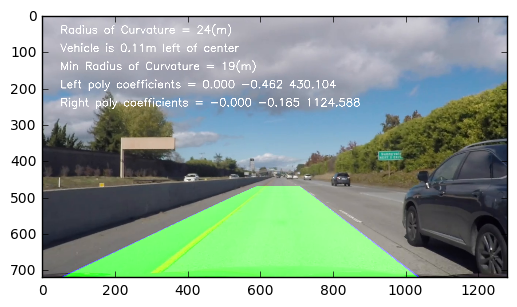

In [22]:
challenge_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
output_clip = clip1.fl_image(image_pipeline)
%time output_clip.write_videofile(output, audio=False)